# Regresor

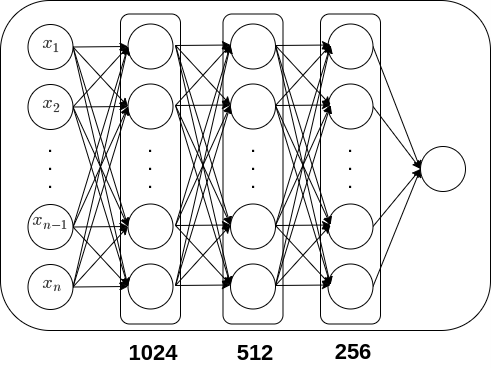

## Validación cruzada con los datos de Natalia
- [x] Agregar la métrica de RMSE.
- [x] Cambiar las gráficas para que se distingan por marcadores y solo con los puntos discretos.
- [x] Probar con los datos GKM.
- [x] Cambiar ReLu por Swish.
- [x] Graficar la función de pérdida.
- [ ] Variar el número de capas ocultas (1 a 4 capas, (relu), (relu, sigmoid), (relu, tanh, sigmoid), (relu, relu, tanh, sigmoid).
- [ ] Hacer una prueba con la función de pérdida MSE, (RMSE).
- [ ] Demodular usando redes neuronales (empezar con pocas neuronas y una sola capa oculta).

In [1]:
#Librerías
import sofa
import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow.keras as ker

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models, regularizers, Sequential, utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from time import time

%store -r

2023-04-03 12:48:25.181935: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-03 12:48:25.206428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def estimation_model(input_dim, layers_props_lst):
    model = ker.Sequential()
    # Capas ocultas
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(**layer_props, input_dim=input_dim))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Regresor
    model.add(ker.layers.Dense(units=1, activation="linear"))

    # Compilar modelo
    model.compile(loss="mean_absolute_error", optimizer="adam")

    return model


def crossvalidation(X, y, n_splits, layer_props, callbacks):
    # Para calcular el tiempo que tarda
    t0 = time()

    # Diccionario donde se almacenarán los puntajes
    scores = {}
    scores["loss"] = []
    scores["mae"] = {"train": [], "test": []}
    scores["r2"] = {"train": [], "test": []}
    scores["rmse"] = {"train": [], "test": []}
    
    # Se hace un K-Fold
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Estandarización de las variables de entrada
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)

        model = estimation_model(X_train.shape[1], layer_props)
        # Guardar la pérdida escalar de prueba (Test scalar loss)
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, verbose=0, callbacks=callbacks
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        
        # Se predice con los datos de entrenamiento
        predictions_train = model.predict(X_train)
        # Se predice con los datos de prueba
        predictions_test = model.predict(X_test_kf)

        # Se crea un dataframe con los resultados para visualizarlos mejor
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )

        # Cálculo del MAE
        mae_score_train = mean_absolute_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        mae_score_test = mean_absolute_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # Cálculo de R²
        r2_score_train = r2_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        r2_score_test = r2_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )
         
        # Cálculo de RMSE
        rmse_score_train = mean_squared_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"],
            squared=False
        )
        rmse_score_test = mean_squared_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"],
            squared=False
        )

        # Anexo a las listas
        scores["loss"].append(loss)
        scores["mae"]["train"].append(mae_score_train)
        scores["mae"]["test"].append(mae_score_test)
        scores["r2"]["train"].append(r2_score_train)
        scores["r2"]["test"].append(r2_score_test)
        scores["rmse"]["train"].append(rmse_score_train)
        scores["rmse"]["test"].append(rmse_score_test)
        
    print(f"Time elapsed: {(time() - t0)/60:.2f} minutes")

    return scores


def test_model(data, n_splits, max_neurons, activations):
    """ Probar un modelo con parámetros establecidos. """
    variables = 17

    # Separando variables
    # Variables
    X = np.array(data[:, 0:variables]).T
    # Etiquetas
    y = np.array(data[:, 19:20]).T
    
    # Propiedades de las capas
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(layer_props)
    callbacks = [
        EarlyStopping(monitor="loss", patience=300, mode="min", restore_best_weights=True)
    ]
    
    return crossvalidation(X, y, n_splits, layer_props, callbacks)


def plot_neurons_scores(scores, max_neurons, scenario):
    score_names = ["mae", "r2", "rmse"]
    markers = ["*", "x", "^", "+"]
    data_type = ["train", "test"]
    
    # Graficar pérdida
    fig_loss = plt.figure(figsize=(20, 4*len(max_neurons)), layout="constrained")
    fig_loss.suptitle(f"{scenario} loss history", size="x-large")
    i = 0
    for score, neurons in zip(scores, max_neurons):
        for k, loss in enumerate(score["loss"]):
            plt.subplot(len(max_neurons), len(score["loss"]), i+1)
            plt.plot(loss.history["loss"], label=f"k = {k+1}")
            # plt.axvline(x=np.argmin(loss.history["loss"]), color="red", linestyle="--",
            #             label="min")
            plt.title(f"{neurons} Max neurons")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.legend(loc="upper right")
            i += 1
    plt.show()
    
    # Graficar puntajes
    fig_scores = plt.figure(figsize=(16, 4*len(scores)), layout="constrained")
    fig_scores.suptitle(f"{scenario} scores")
    i = 0
    for sn in score_names:
        for dt in data_type:
            plt.subplot(len(score_names), len(data_type), i+1)
            for j, (score, neurons) in enumerate(zip(scores, max_neurons)):
                points = score[sn][dt]

                k = np.arange(len(points), dtype = np.uint8) + 1
                 
                plt.scatter(k, points, marker=markers[j], label=f"n = {neurons}, µ = {np.mean(points):.3f}",
                               s = 100)
                
            plt.title(f"{'Train' if dt == 'train' else 'Test'}")
            plt.xlabel("k-fold")
            plt.xticks(k)
            plt.ylabel("MAE" if sn == "mae" else "R²" if sn == "r2" else "RMSE")
            plt.grid(True)
            plt.legend(loc="upper right")
            i += 1
    plt.show()

    
def plot_activations_scores(scores, scenario):
    score_names = ["mae", "r2", "rmse"]
    markers = ["o", "v", "X", "P"]
    data_type = ["train", "test"]
    
    # Graficar pérdida
    fig_loss = plt.figure(figsize=(20, 4*len(max_neurons)), layout="constrained")
    fig_loss.suptitle(f"{scenario} loss history", size="x-large")
    i = 0
    for j, (score, neurons) in enumerate(zip(scores, max_neurons)):
        for k, loss in enumerate(score["loss"]):
            plt.subplot(len(max_neurons), len(score["loss"]), i+1)
            plt.plot(loss.history["loss"], label=f"k = {k+1}")
            # plt.axvline(x=np.argmin(loss.history["loss"]), color="red", linestyle="--",
            #             label="min")
            plt.title(f"{'FCM' if j%2 == 0 else 'GKM'} {'ReLu' if j<2 else 'Swish'}")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.legend(loc="upper right")
            i += 1
    plt.show()
            
    # Graficar puntajes
    fig_scores = plt.figure(figsize=(16, 4*len(scores)), layout="constrained")
    fig_scores.suptitle(f"{scenario} scores")
    i = 0
    for sn in score_names:
        for dt in data_type:
            plt.subplot(len(score_names), len(data_type), i+1)
            for j, (score, neurons) in enumerate(zip(scores, max_neurons)):
                points = score[sn][dt]

                k = np.arange(len(points), dtype = np.uint8) + 1
                 
                plt.scatter(k, points, marker=markers[j], 
                            label=f"{'FCM' if j%2 == 0 else 'GKM'} {'ReLu' if j<2 else 'Swish'}, µ = {np.mean(points):.3f}",
                            s = 100)
                
            plt.title(f"{'Train' if dt == 'train' else 'Test'}")
            plt.xlabel("k-fold")
            plt.xticks(k)
            plt.ylabel("MAE" if sn == "mae" else "R²" if sn == "r2" else "RMSE")
            plt.grid(True)
            plt.legend(loc="upper right")
            i += 1
    plt.show()
    
    
def calc_once(varname, fn, args):
    """ Calcular una variable una sola vez. """
    if varname not in globals():
        return fn(**args)
    return eval(varname)

## FCM

In [3]:
# Para leer los datos
data_file_FCM = "../Databases/CaractFCM.csv"
df_FCM = pl.read_csv(data_file_FCM, dtypes=[pl.Float64], has_header=False)

# Separación por escenarios
# Datos sin fibra (B2B)
df_FCM_B2B = df_FCM[0:987, :]
# Datos con fibra óptica a 0dBm
df_FCM_fiber0 = df_FCM[988:1520, :]
# Datos con fibra óptica a 9dBm
df_FCM_fiber9 = df_FCM[1521:, :]

### Crosvalidación para FCM B2B variando el número de neuronas por capa

In [4]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_B2B = calc_once("scores_FCM_1024_B2B", test_model, args)

[{'units': 1024, 'activation': 'relu'}, {'units': 512, 'activation': 'tanh'}, {'units': 256, 'activation': 'sigmoid'}]
Needed iterations: 2679
7/7 [==============================] - 0s 1ms/step
Needed iterations: 2972
7/7 [==============================] - 0s 2ms/step
Needed iterations: 2116
7/7 [==============================] - 0s 2ms/step
Needed iterations: 3096
7/7 [==============================] - 0s 1ms/step
Needed iterations: 2520
7/7 [==============================] - 0s 2ms/step
Time elapsed: 14.41 minutes


In [5]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_B2B = calc_once("scores_FCM_512_B2B", test_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 2567
7/7 [==============================] - 0s 1ms/step
Needed iterations: 5000
7/7 [==============================] - 0s 929us/step
Needed iterations: 2057
7/7 [==============================] - 0s 1ms/step
Needed iterations: 3644
7/7 [==============================] - 0s 987us/step
Needed iterations: 4588
7/7 [==============================] - 0s 953us/step
Time elapsed: 7.30 minutes


In [6]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_B2B = calc_once("scores_FCM_256_B2B", test_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 4999
7/7 [==============================] - 0s 884us/step
Needed iterations: 5000
7/7 [==============================] - 0s 823us/step
Needed iterations: 5000
7/7 [==============================] - 0s 1ms/step
Needed iterations: 4929
7/7 [==============================] - 0s 819us/step
Needed iterations: 5000
7/7 [==============================] - 0s 870us/step
Time elapsed: 5.20 minutes


In [7]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_B2B = calc_once("scores_FCM_128_B2B", test_model, args)

[{'units': 128, 'activation': 'relu'}, {'units': 64, 'activation': 'tanh'}, {'units': 32, 'activation': 'sigmoid'}]
Needed iterations: 5000
7/7 [==============================] - 0s 836us/step
Needed iterations: 5000
7/7 [==============================] - 0s 878us/step
Needed iterations: 5000
7/7 [==============================] - 0s 828us/step
Needed iterations: 5000
7/7 [==============================] - 0s 888us/step
Needed iterations: 5000
7/7 [==============================] - 0s 827us/step
Time elapsed: 4.44 minutes


In [8]:
%store scores_FCM_1024_B2B
%store scores_FCM_512_B2B 
%store scores_FCM_256_B2B
%store scores_FCM_128_B2B

Stored 'scores_FCM_1024_B2B' (dict)
Stored 'scores_FCM_512_B2B' (dict)
Stored 'scores_FCM_256_B2B' (dict)
Stored 'scores_FCM_128_B2B' (dict)


#### Gráficas de puntajes (FCM B2B)

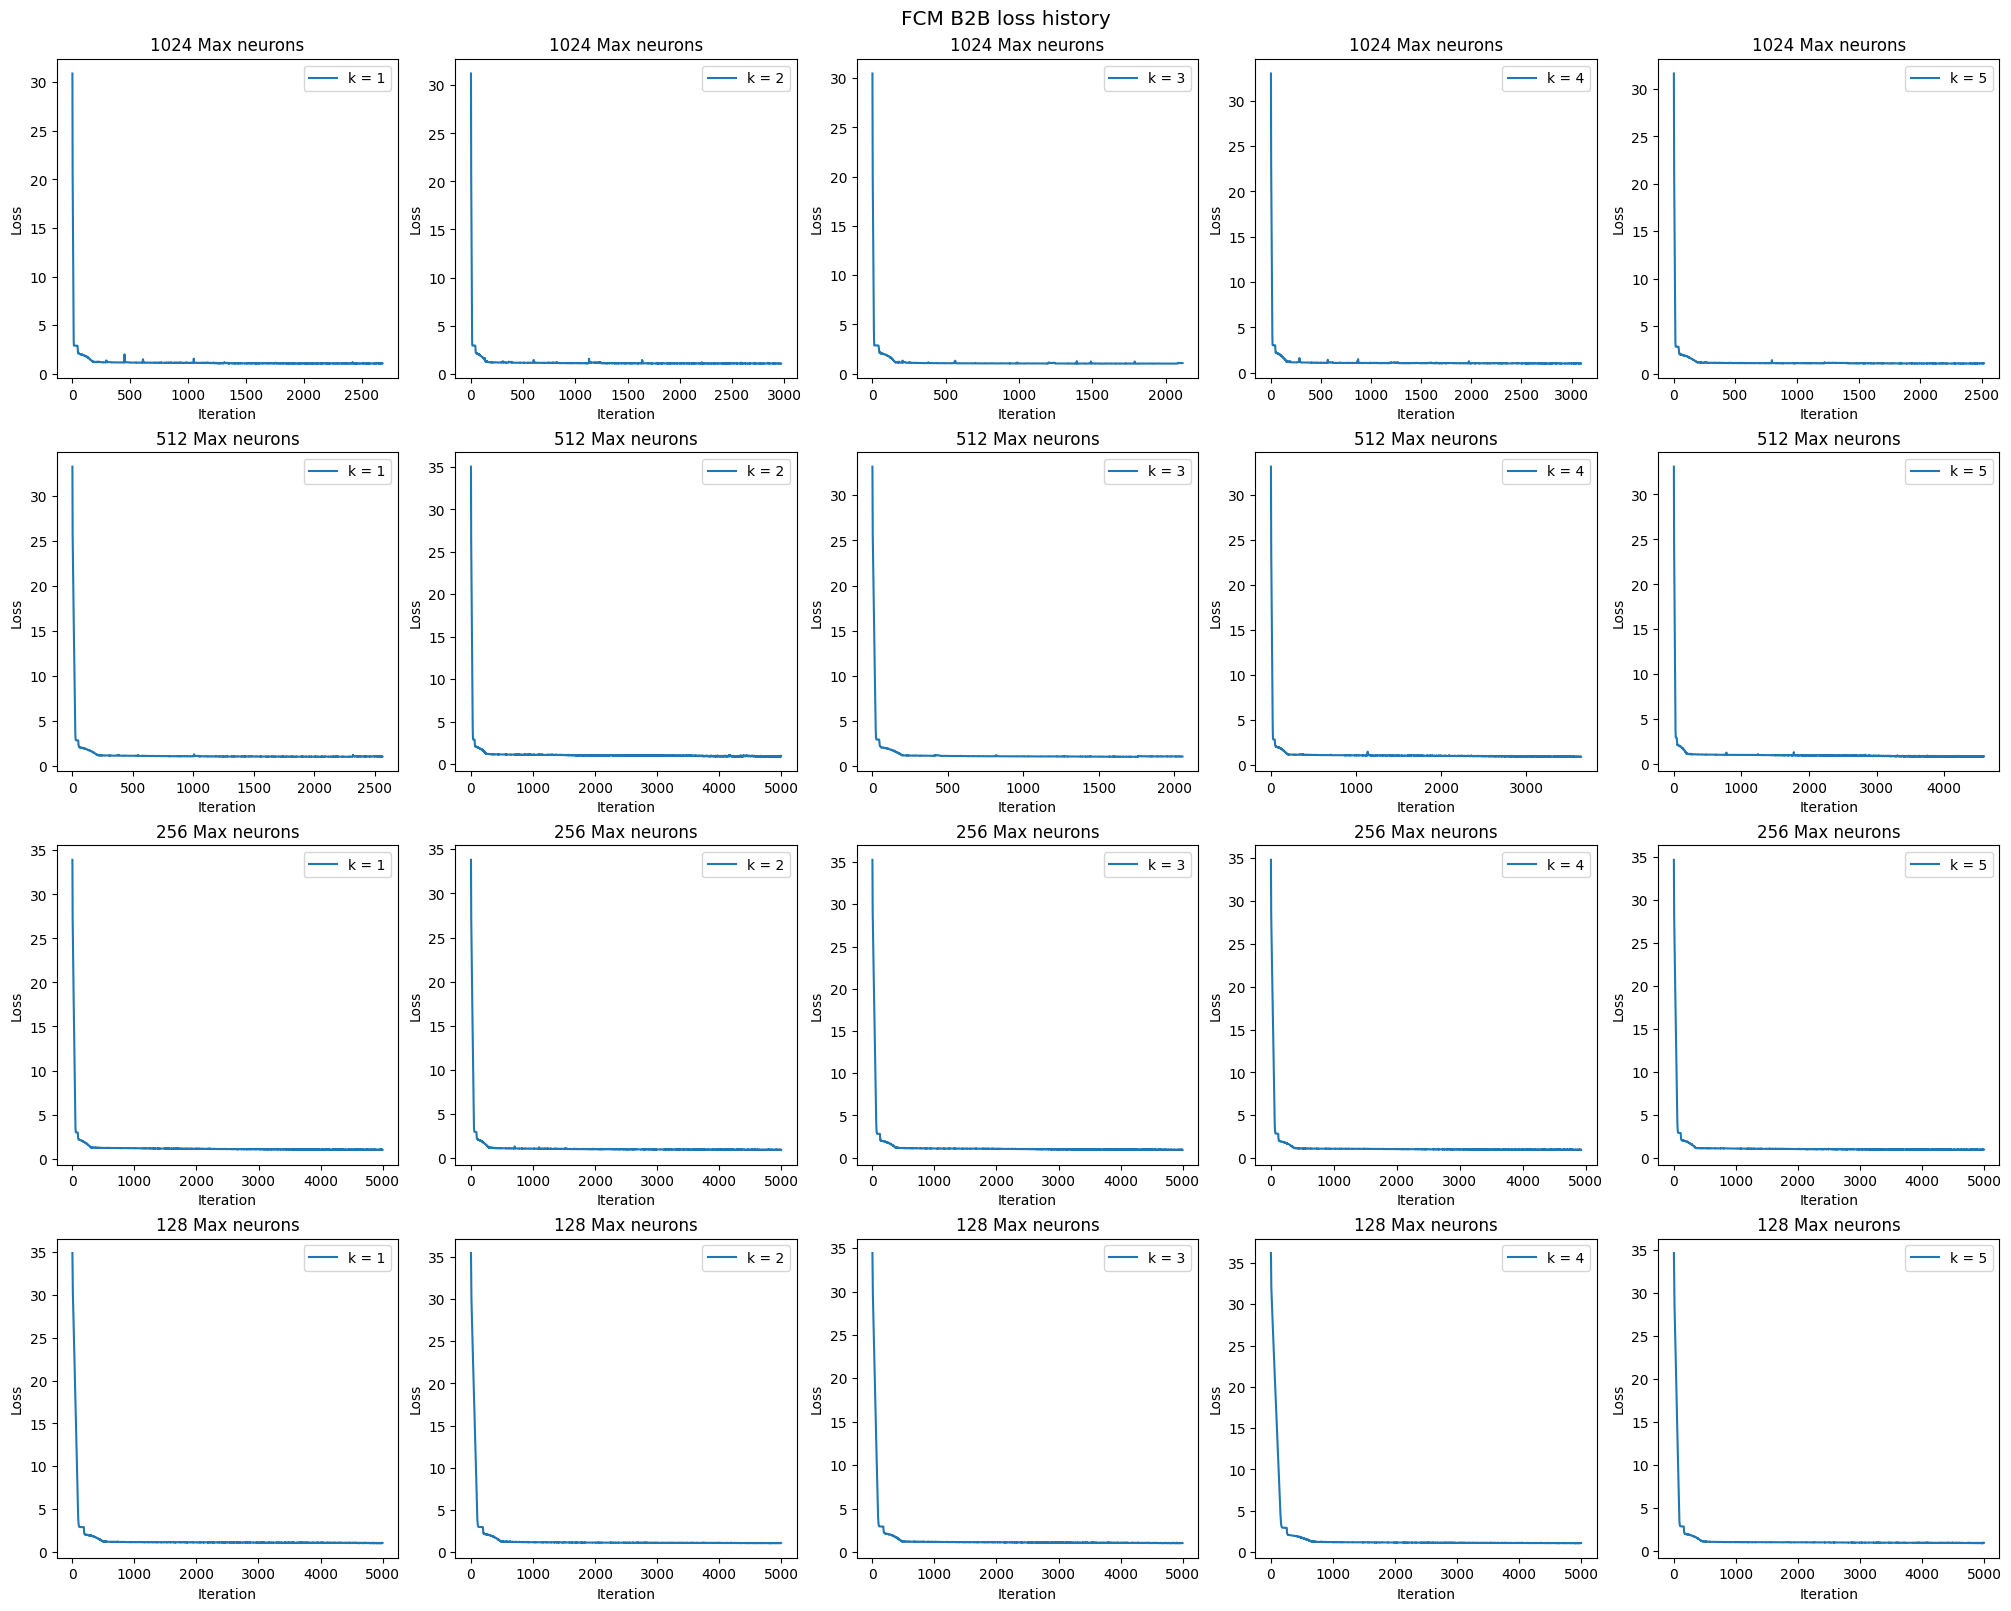

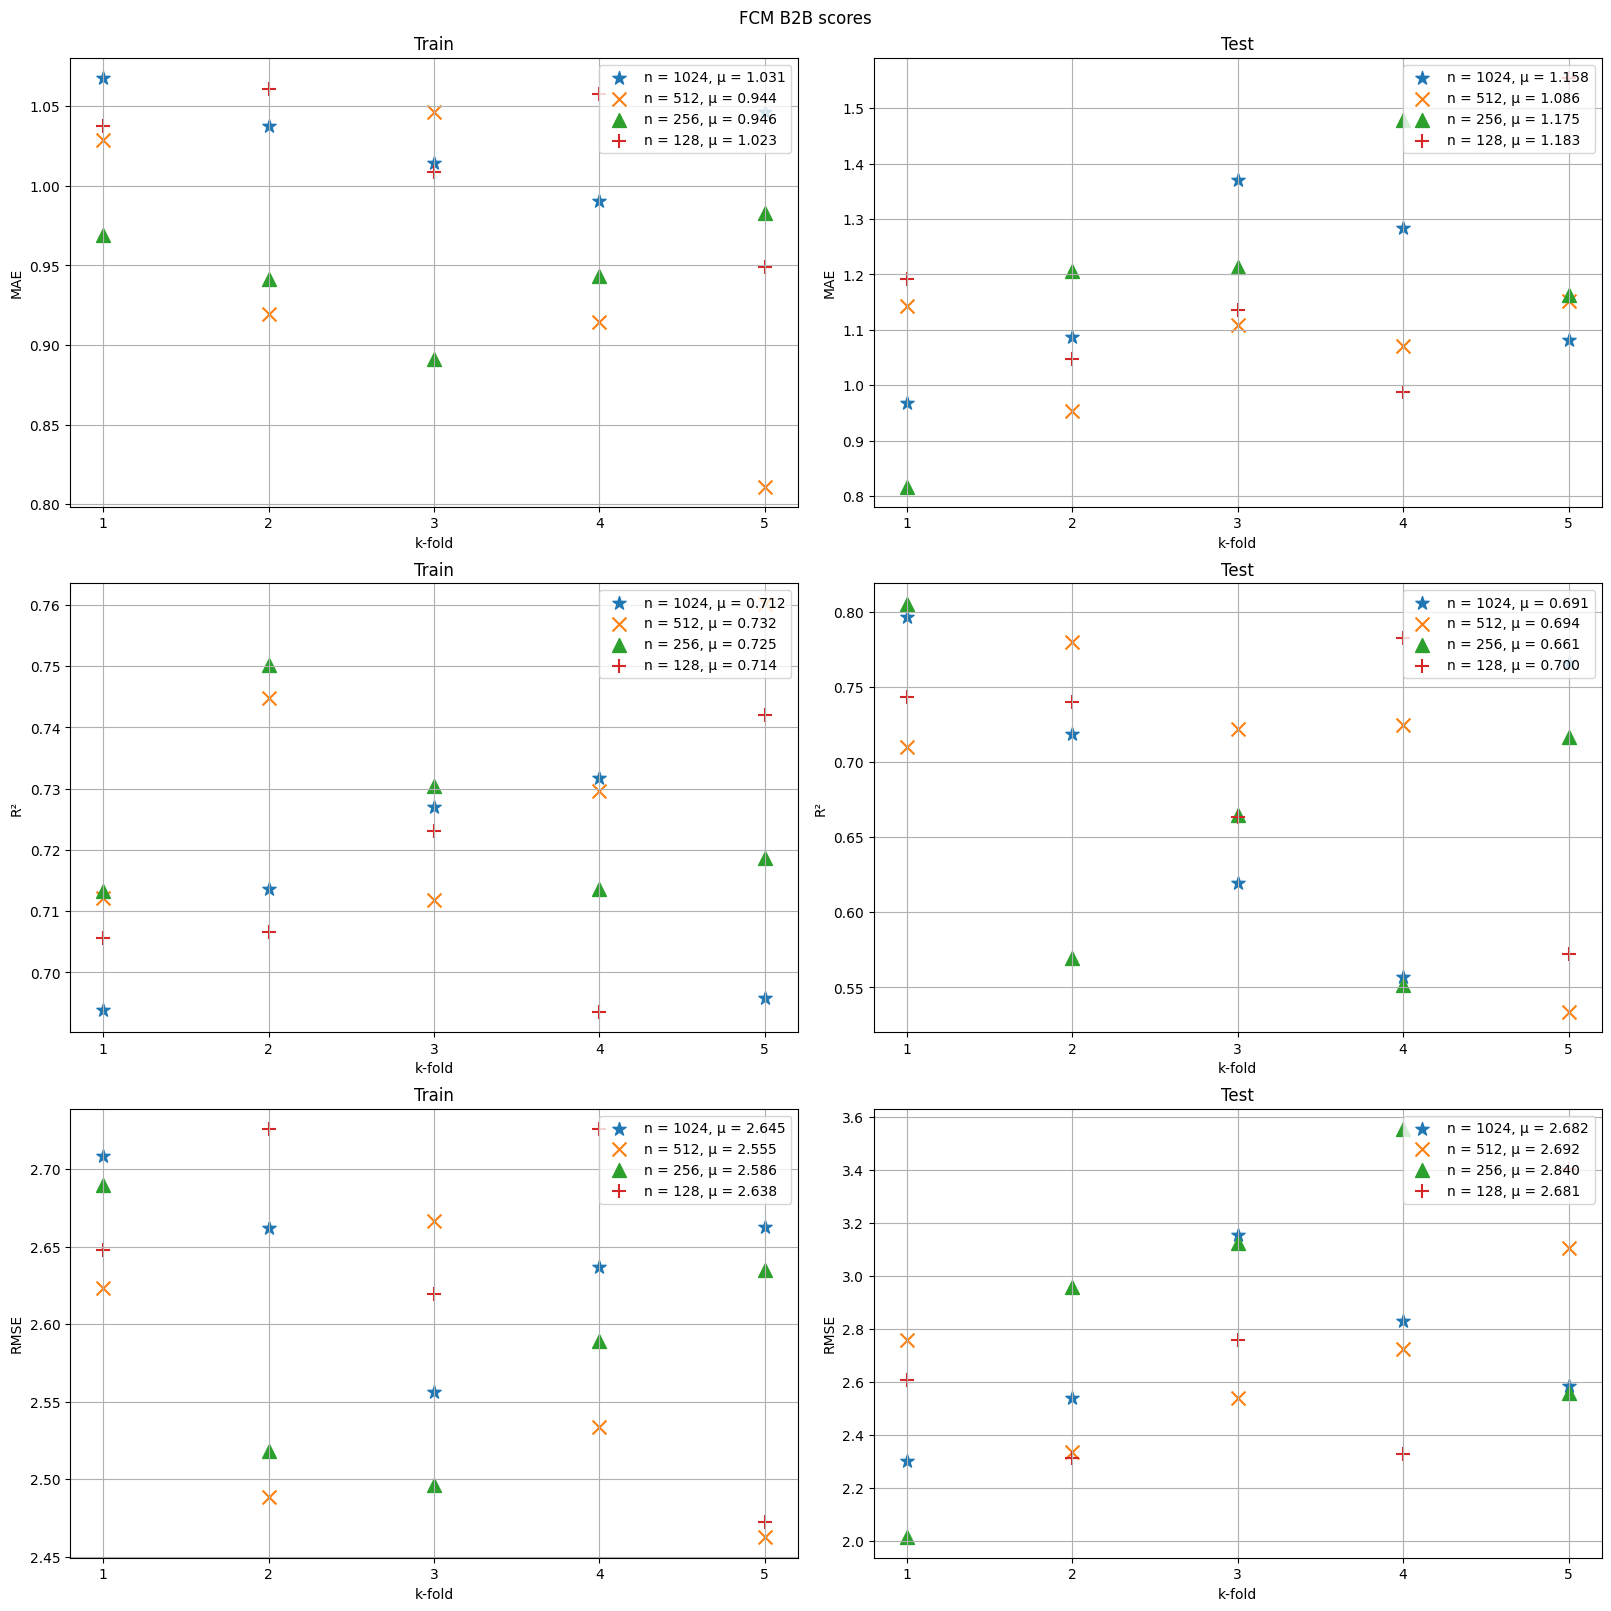

In [9]:
scores = [scores_FCM_1024_B2B, scores_FCM_512_B2B, scores_FCM_256_B2B, scores_FCM_128_B2B]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "FCM B2B")

### Crosvalidación para FCM con fibra óptica a 0dBm variando el número de neuronas por capa

In [10]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_fiber0 = calc_once("scores_FCM_1024_fiber0", test_model, args)

[{'units': 1024, 'activation': 'relu'}, {'units': 512, 'activation': 'tanh'}, {'units': 256, 'activation': 'sigmoid'}]
Needed iterations: 2779
4/4 [==============================] - 0s 2ms/step
Needed iterations: 3591
4/4 [==============================] - 0s 2ms/step
Needed iterations: 2702
4/4 [==============================] - 0s 2ms/step
Needed iterations: 2496
4/4 [==============================] - 0s 2ms/step
Needed iterations: 2551
4/4 [==============================] - 0s 1ms/step
Time elapsed: 8.73 minutes


In [11]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_fiber0 = calc_once("scores_FCM_512_fiber0", test_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 3090
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 4270
4/4 [==============================] - 0s 1ms/step
Needed iterations: 4696
4/4 [==============================] - 0s 1ms/step
Needed iterations: 3283
4/4 [==============================] - 0s 1ms/step
Time elapsed: 4.73 minutes


In [12]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_fiber0 = calc_once("scores_FCM_256_fiber0", test_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 937us/step
Needed iterations: 1928
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 4276
4/4 [==============================] - 0s 898us/step
Time elapsed: 2.53 minutes


In [13]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_fiber0 = calc_once("scores_FCM_128_fiber0", test_model, args)

[{'units': 128, 'activation': 'relu'}, {'units': 64, 'activation': 'tanh'}, {'units': 32, 'activation': 'sigmoid'}]
Needed iterations: 4695
4/4 [==============================] - 0s 995us/step
Needed iterations: 4691
4/4 [==============================] - 0s 977us/step
Needed iterations: 3166
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 878us/step
Needed iterations: 3543
4/4 [==============================] - 0s 996us/step
Time elapsed: 2.17 minutes


In [14]:
%store scores_FCM_1024_fiber0 
%store scores_FCM_512_fiber0 
%store scores_FCM_256_fiber0 
%store scores_FCM_128_fiber0

Stored 'scores_FCM_1024_fiber0' (dict)
Stored 'scores_FCM_512_fiber0' (dict)
Stored 'scores_FCM_256_fiber0' (dict)
Stored 'scores_FCM_128_fiber0' (dict)


#### Gráficas de puntajes (FCM con fibra óptica a 0dBm)

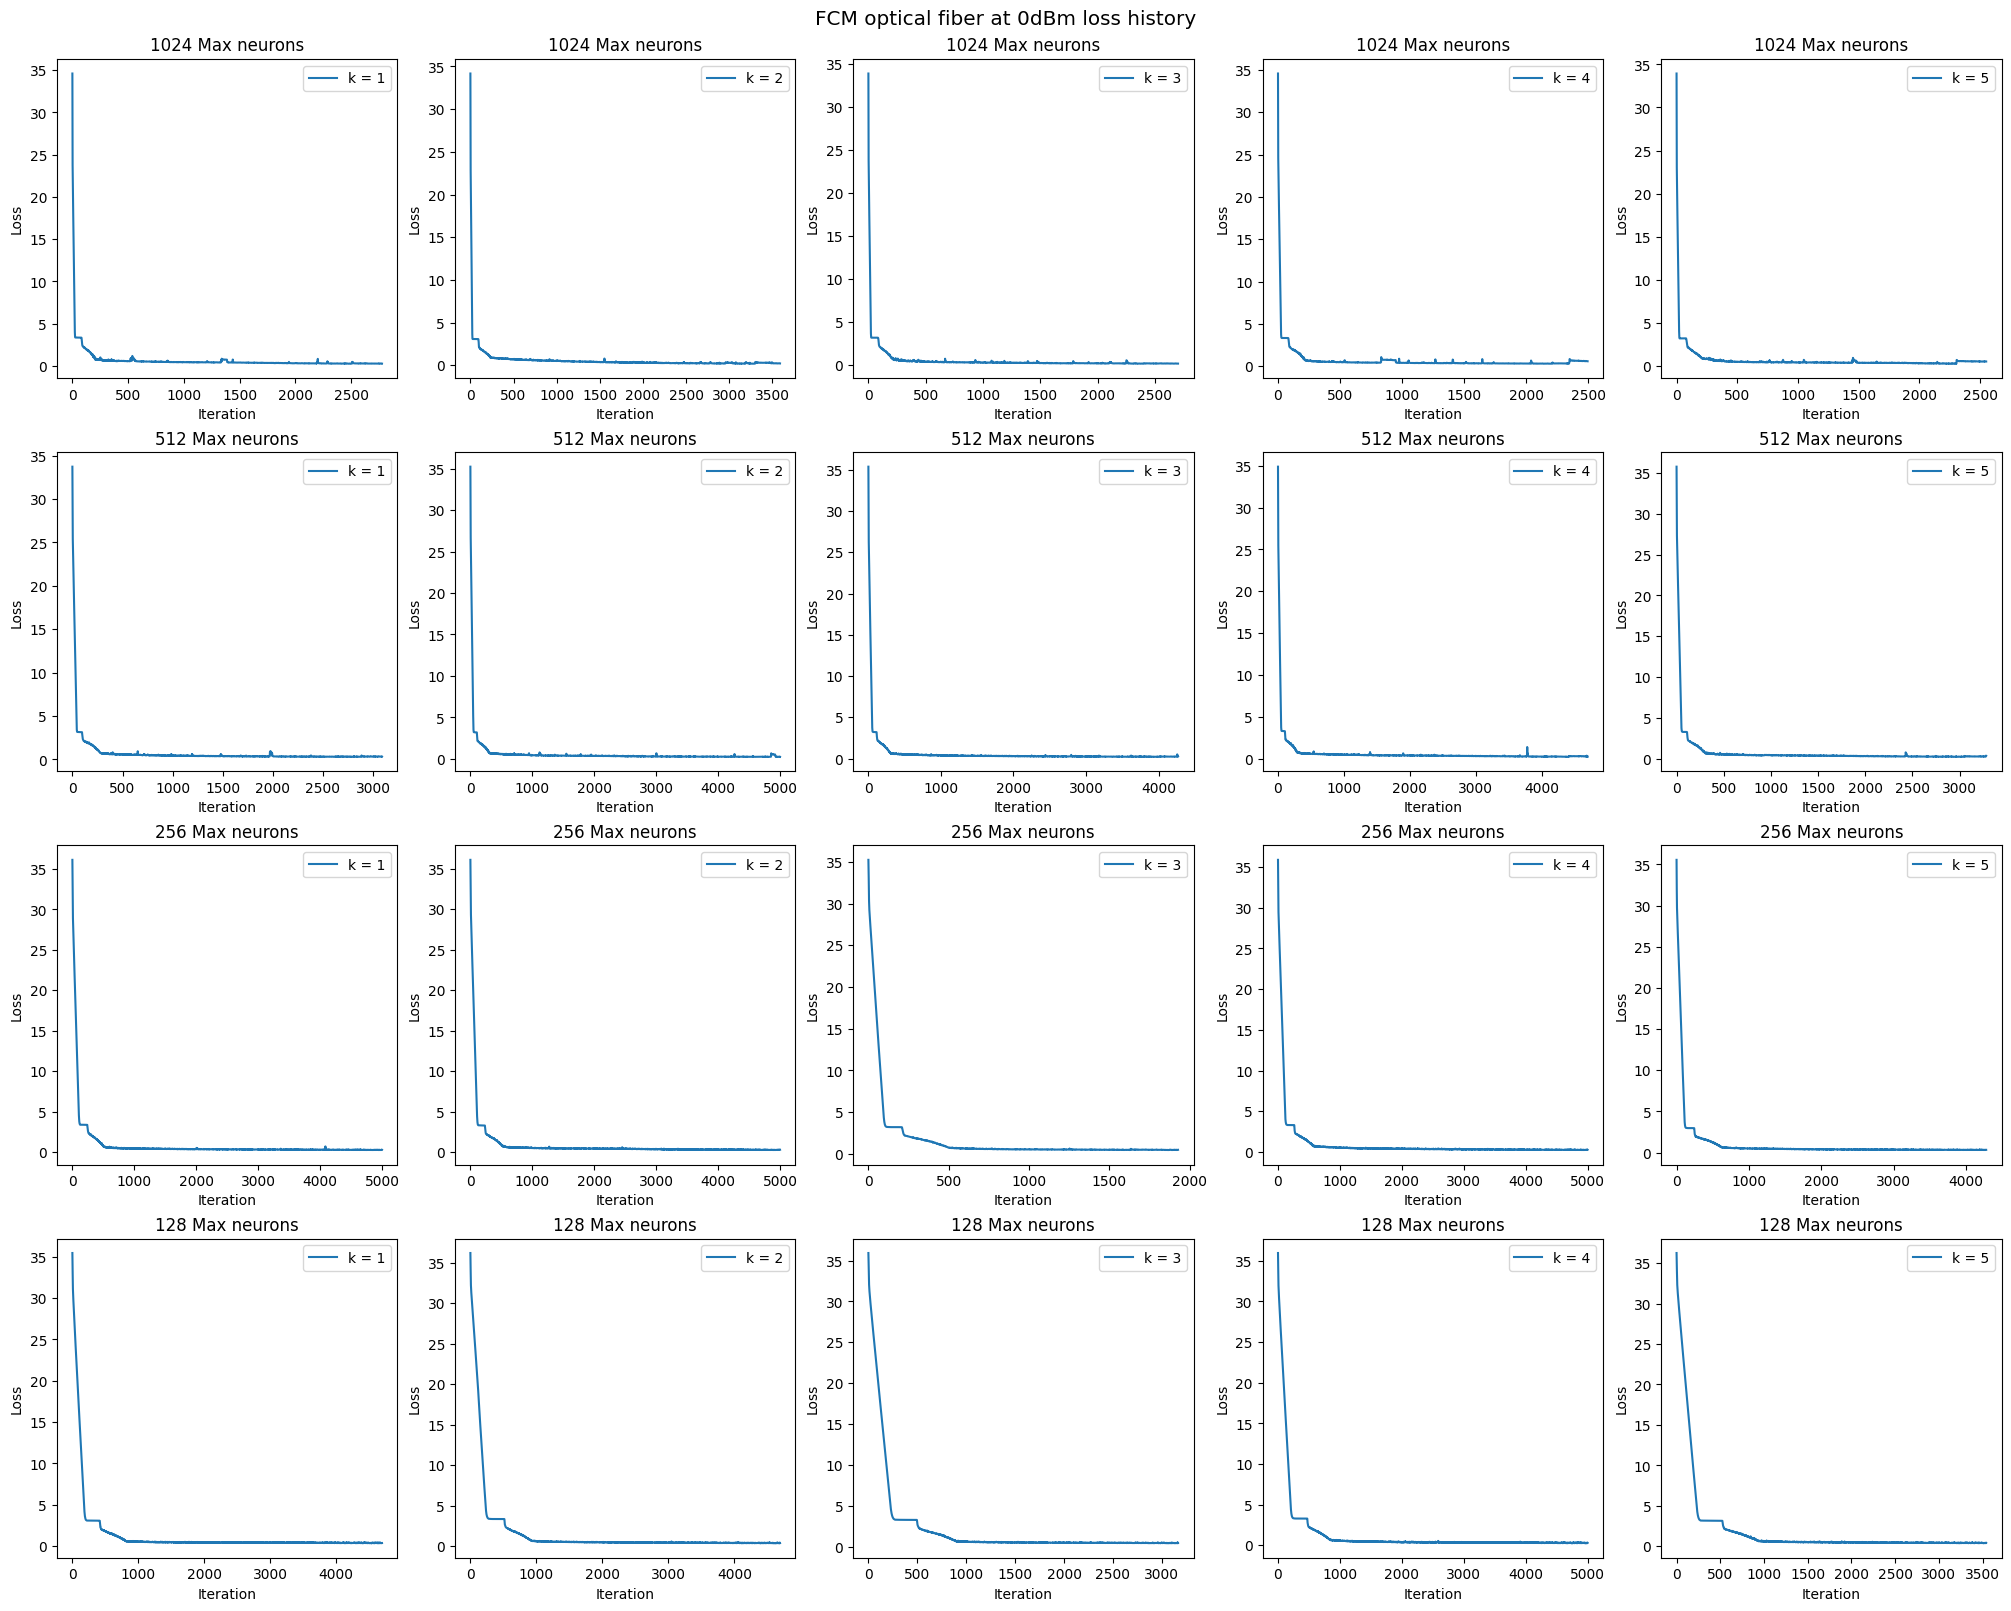

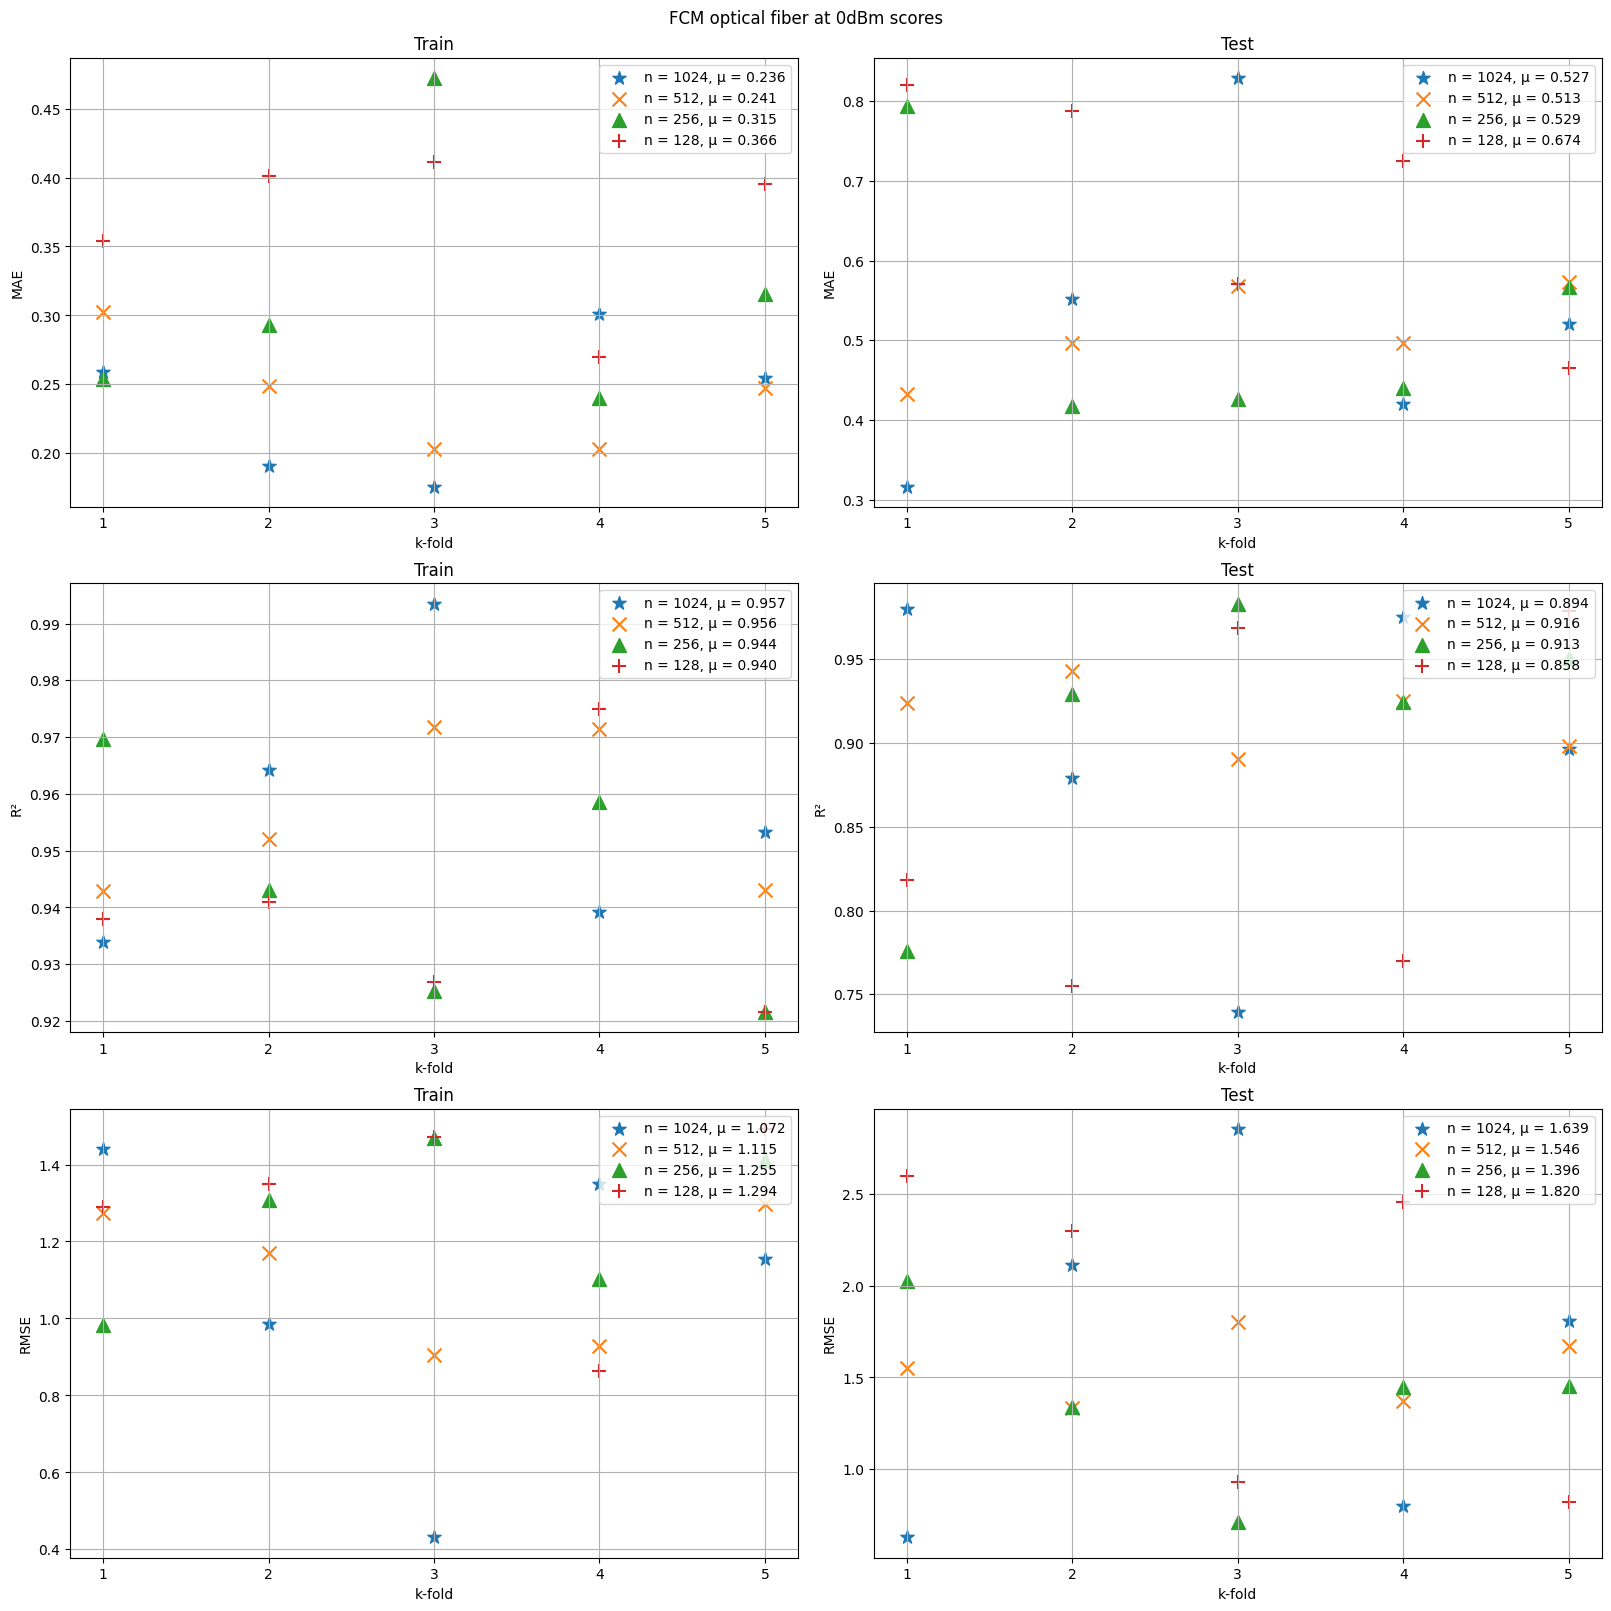

In [15]:
scores = [scores_FCM_1024_fiber0, scores_FCM_512_fiber0, scores_FCM_256_fiber0, scores_FCM_128_fiber0]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "FCM optical fiber at 0dBm")

### Crosvalidación para FCM con fibra óptica a 9dBm variando el número de neuronas por capa

In [16]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_fiber9 = calc_once("scores_FCM_1024_fiber9", test_model, args)

[{'units': 1024, 'activation': 'relu'}, {'units': 512, 'activation': 'tanh'}, {'units': 256, 'activation': 'sigmoid'}]
Needed iterations: 1160
6/6 [==============================] - 0s 2ms/step
Needed iterations: 1195
6/6 [==============================] - 0s 1ms/step
Needed iterations: 1970
6/6 [==============================] - 0s 2ms/step
Needed iterations: 1185
6/6 [==============================] - 0s 2ms/step
Needed iterations: 1302
6/6 [==============================] - 0s 2ms/step
Time elapsed: 6.89 minutes


In [17]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_fiber9 = calc_once("scores_FCM_512_fiber9", test_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 1500
6/6 [==============================] - 0s 1ms/step
Needed iterations: 990
6/6 [==============================] - 0s 1ms/step
Needed iterations: 1769
6/6 [==============================] - 0s 1ms/step
Needed iterations: 1715
6/6 [==============================] - 0s 1ms/step
Needed iterations: 908
6/6 [==============================] - 0s 1ms/step
Time elapsed: 2.60 minutes


In [18]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_fiber9 = calc_once("scores_FCM_256_fiber9", test_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 1460
6/6 [==============================] - 0s 1ms/step
Needed iterations: 1457
6/6 [==============================] - 0s 908us/step
Needed iterations: 1861
6/6 [==============================] - 0s 885us/step
Needed iterations: 1894
6/6 [==============================] - 0s 936us/step
Needed iterations: 1913
6/6 [==============================] - 0s 912us/step
Time elapsed: 1.66 minutes


In [19]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_fiber9 = calc_once("scores_FCM_128_fiber9", test_model, args)

[{'units': 128, 'activation': 'relu'}, {'units': 64, 'activation': 'tanh'}, {'units': 32, 'activation': 'sigmoid'}]
Needed iterations: 1860
6/6 [==============================] - 0s 984us/step
Needed iterations: 2764
6/6 [==============================] - 0s 888us/step
Needed iterations: 1627
6/6 [==============================] - 0s 895us/step
Needed iterations: 2186
6/6 [==============================] - 0s 965us/step
Needed iterations: 2829
6/6 [==============================] - 0s 916us/step
Time elapsed: 1.85 minutes


In [20]:
%store scores_FCM_1024_fiber9
%store scores_FCM_512_fiber9 
%store scores_FCM_256_fiber9 
%store scores_FCM_128_fiber9

Stored 'scores_FCM_1024_fiber9' (dict)
Stored 'scores_FCM_512_fiber9' (dict)
Stored 'scores_FCM_256_fiber9' (dict)
Stored 'scores_FCM_128_fiber9' (dict)


#### Gráficas de puntajes (FCM con fibra óptica a 9dBm)

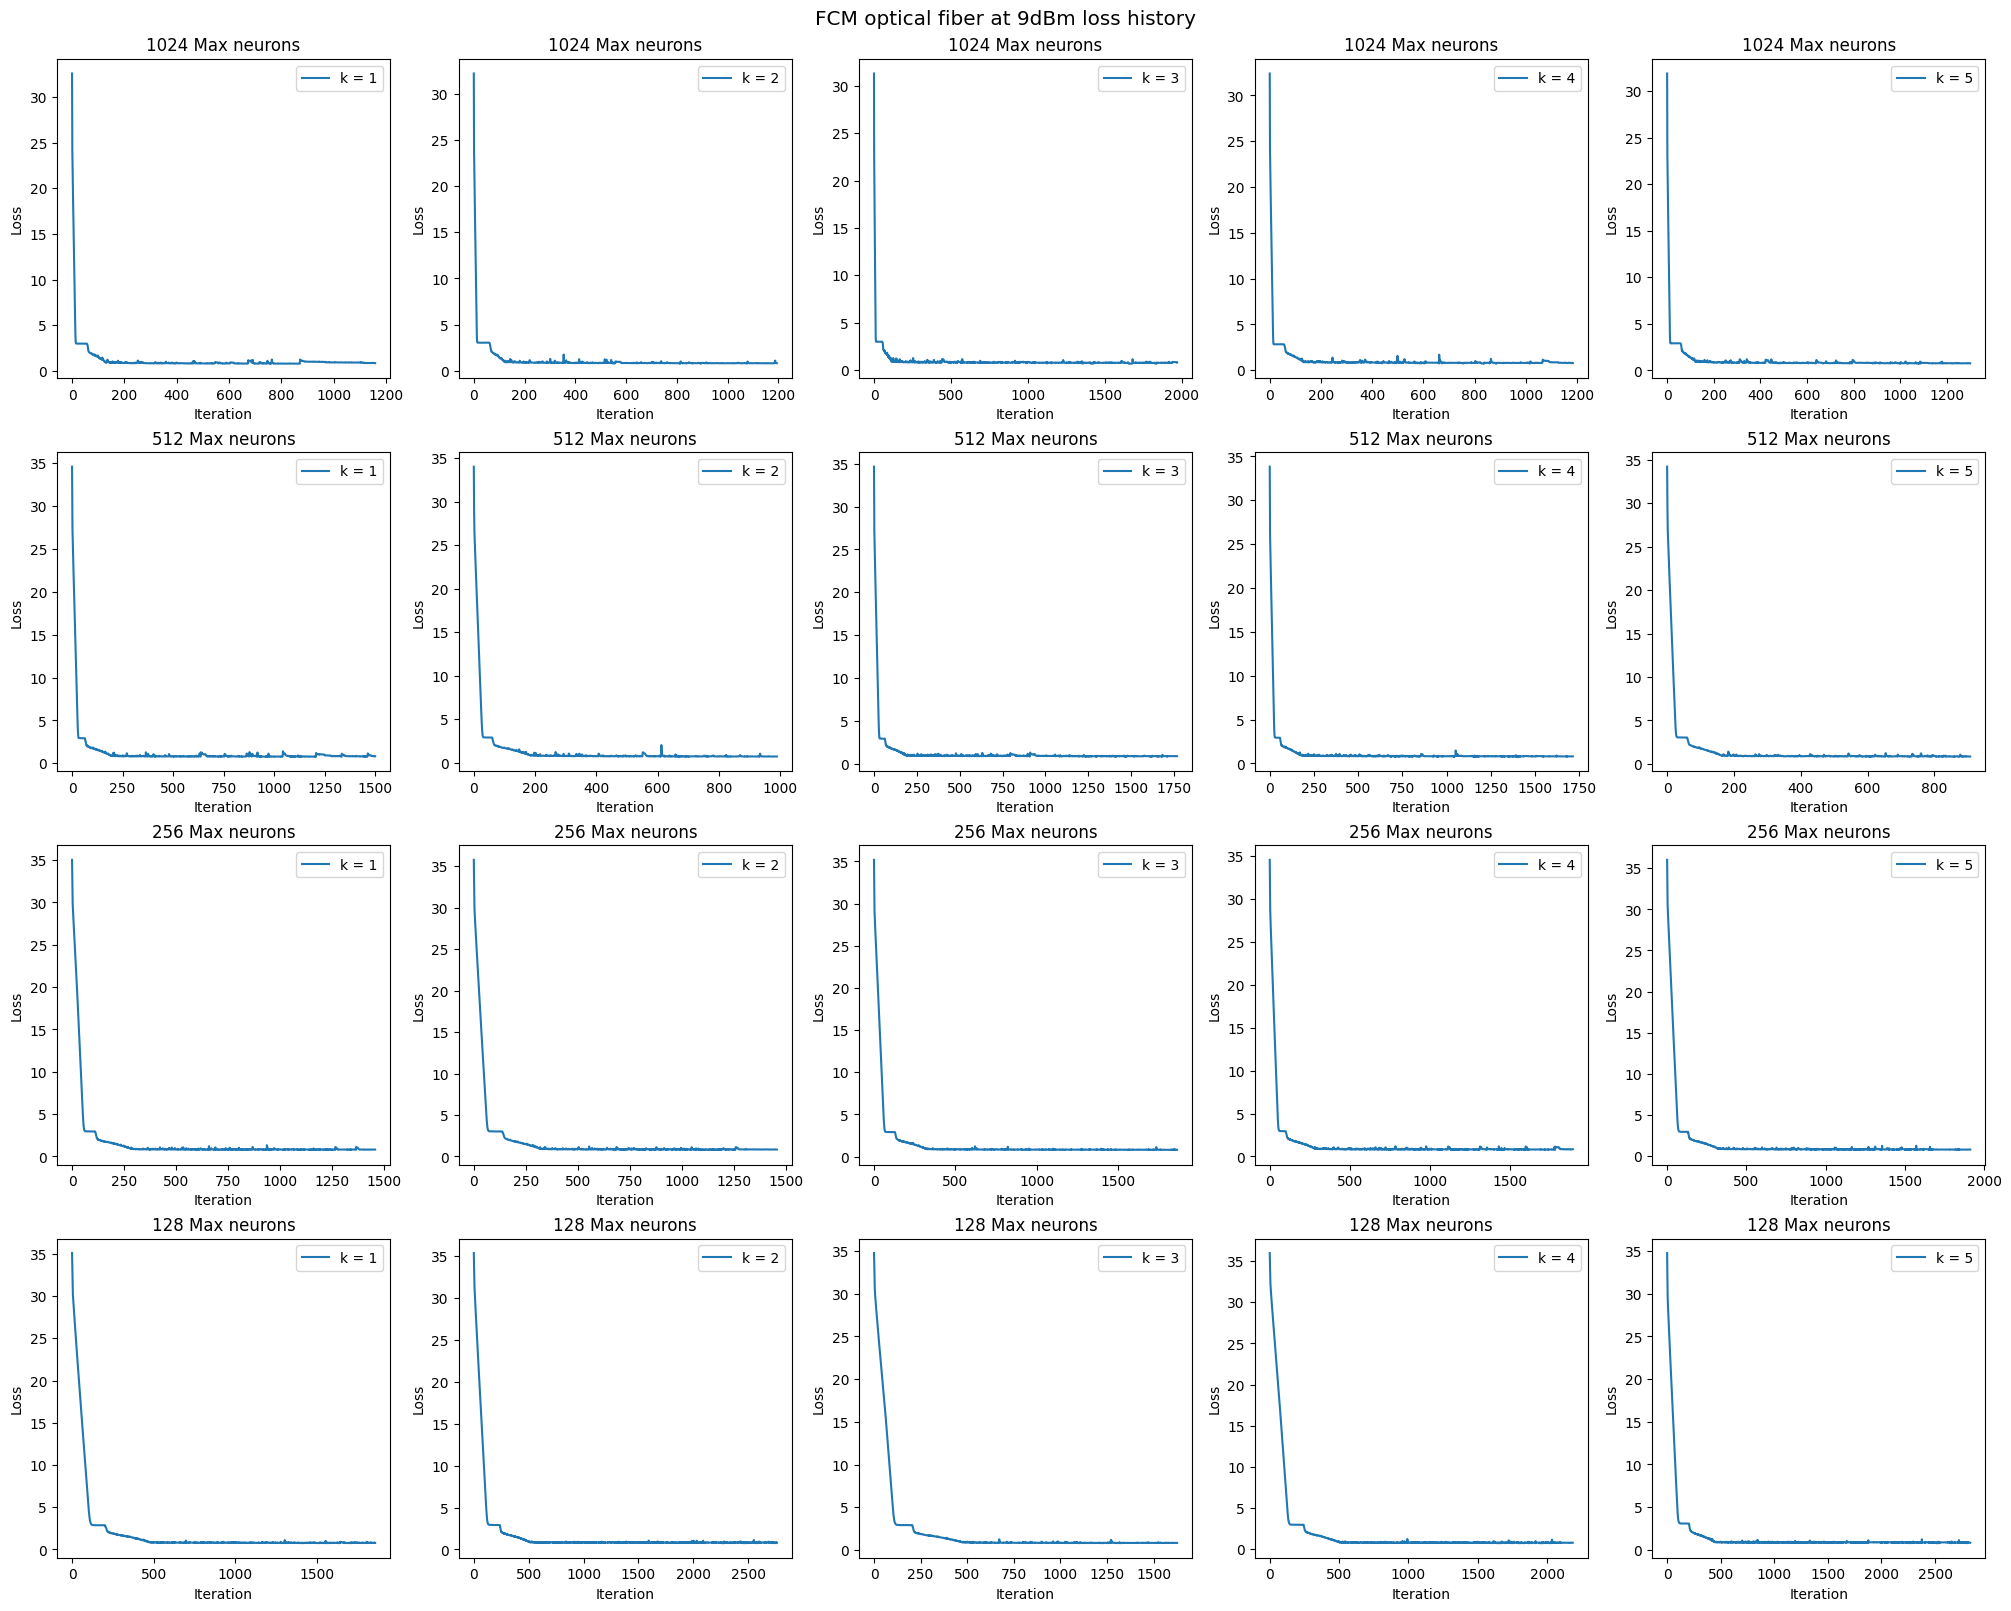

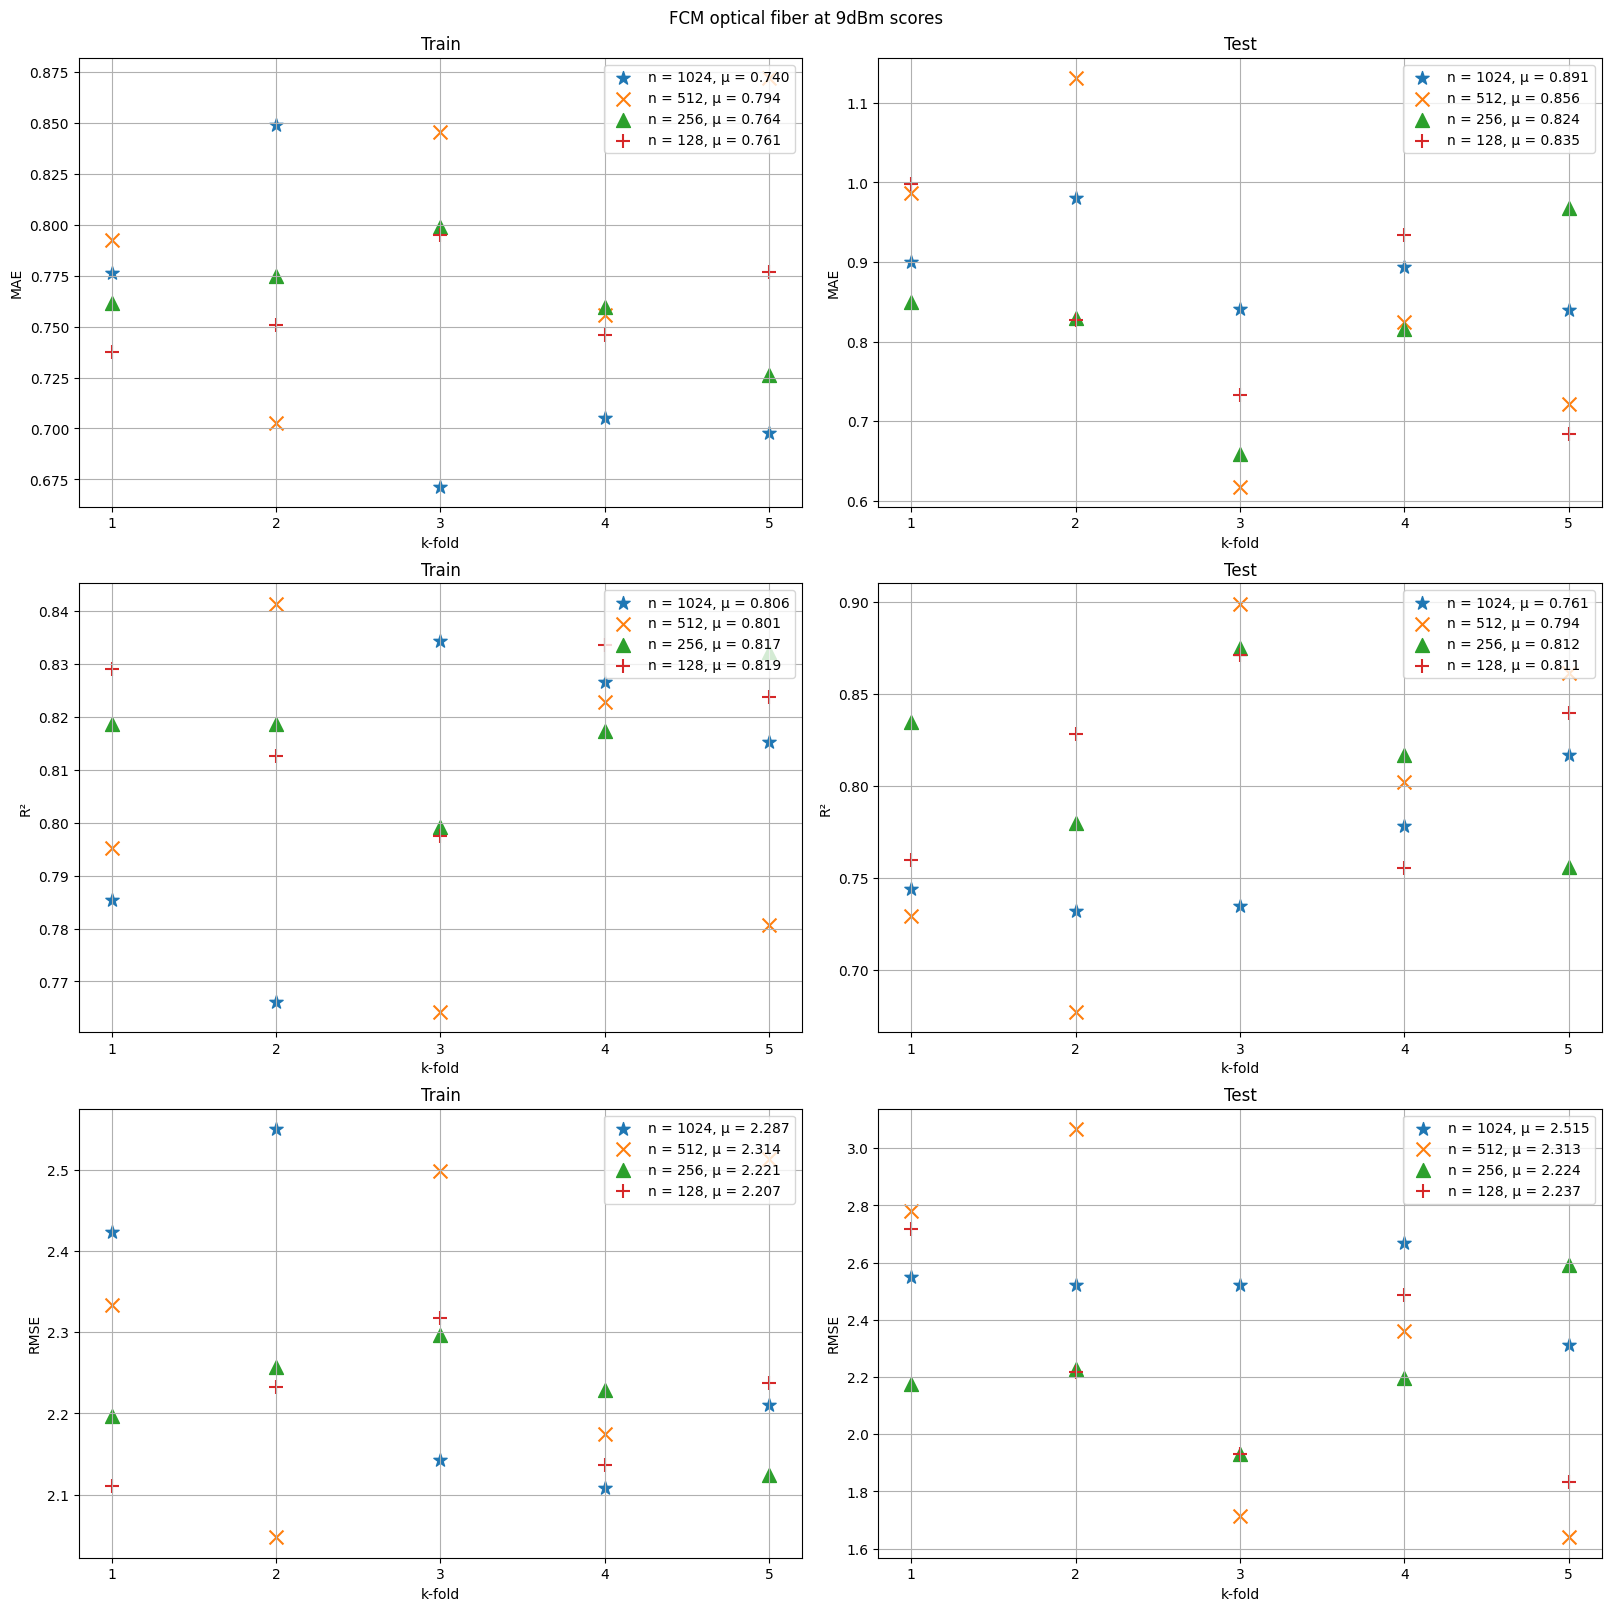

In [21]:
scores = [scores_FCM_1024_fiber9, scores_FCM_512_fiber9, scores_FCM_256_fiber9, scores_FCM_128_fiber9]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "FCM optical fiber at 9dBm")

## GKM

In [22]:
# Para leer los datos
data_file_GKM = "../Databases/CaractGKM.csv"
df_GKM = pl.read_csv(data_file_GKM, dtypes=[pl.Float64], infer_schema_length = 10000, has_header=False)

# Separación por escenarios
# Datos sin fibra (B2B)
df_GKM_B2B = df_GKM[0:987, :]
# Datos con fibra óptica a 0dBm
df_GKM_fiber0 = df_GKM[988:1520, :]
# Datos con fibra óptica a 9dBm
df_GKM_fiber9 = df_GKM[1521:, :]

### Crosvalidación para GKM B2B variando el número de neuronas por capa

In [23]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_B2B = calc_once("scores_GKM_1024_B2B", test_model, args)

[{'units': 1024, 'activation': 'relu'}, {'units': 512, 'activation': 'tanh'}, {'units': 256, 'activation': 'sigmoid'}]
Needed iterations: 2134
7/7 [==============================] - 0s 1ms/step
Needed iterations: 2525
7/7 [==============================] - 0s 1ms/step
Needed iterations: 2026
7/7 [==============================] - 0s 1ms/step
Needed iterations: 3254
7/7 [==============================] - 0s 1ms/step
Needed iterations: 1818
7/7 [==============================] - 0s 1ms/step
Time elapsed: 12.76 minutes


In [24]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_B2B = calc_once("scores_GKM_512_B2B", test_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 5000
7/7 [==============================] - 0s 1ms/step
Needed iterations: 2114
7/7 [==============================] - 0s 1ms/step
Needed iterations: 2606
7/7 [==============================] - 0s 1ms/step
Needed iterations: 3396
7/7 [==============================] - 0s 1ms/step
Needed iterations: 2475
7/7 [==============================] - 0s 1ms/step
Time elapsed: 6.34 minutes


In [25]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_B2B = calc_once("scores_GKM_256_B2B", test_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 4098
7/7 [==============================] - 0s 837us/step
Needed iterations: 4576
7/7 [==============================] - 0s 756us/step
Needed iterations: 3137
7/7 [==============================] - 0s 859us/step
Needed iterations: 5000
7/7 [==============================] - 0s 895us/step
Needed iterations: 3268
7/7 [==============================] - 0s 766us/step
Time elapsed: 4.12 minutes


In [26]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_B2B = calc_once("scores_GKM_128_B2B", test_model, args)

[{'units': 128, 'activation': 'relu'}, {'units': 64, 'activation': 'tanh'}, {'units': 32, 'activation': 'sigmoid'}]
Needed iterations: 4025
7/7 [==============================] - 0s 829us/step
Needed iterations: 4947
7/7 [==============================] - 0s 860us/step
Needed iterations: 4222
7/7 [==============================] - 0s 769us/step
Needed iterations: 2204
7/7 [==============================] - 0s 868us/step
Needed iterations: 2759
7/7 [==============================] - 0s 812us/step
Time elapsed: 3.17 minutes


In [27]:
%store scores_GKM_1024_B2B
%store scores_GKM_512_B2B
%store scores_GKM_256_B2B
%store scores_GKM_128_B2B

Stored 'scores_GKM_1024_B2B' (dict)
Stored 'scores_GKM_512_B2B' (dict)
Stored 'scores_GKM_256_B2B' (dict)
Stored 'scores_GKM_128_B2B' (dict)


#### Gráficas de puntajes (GKM B2B)

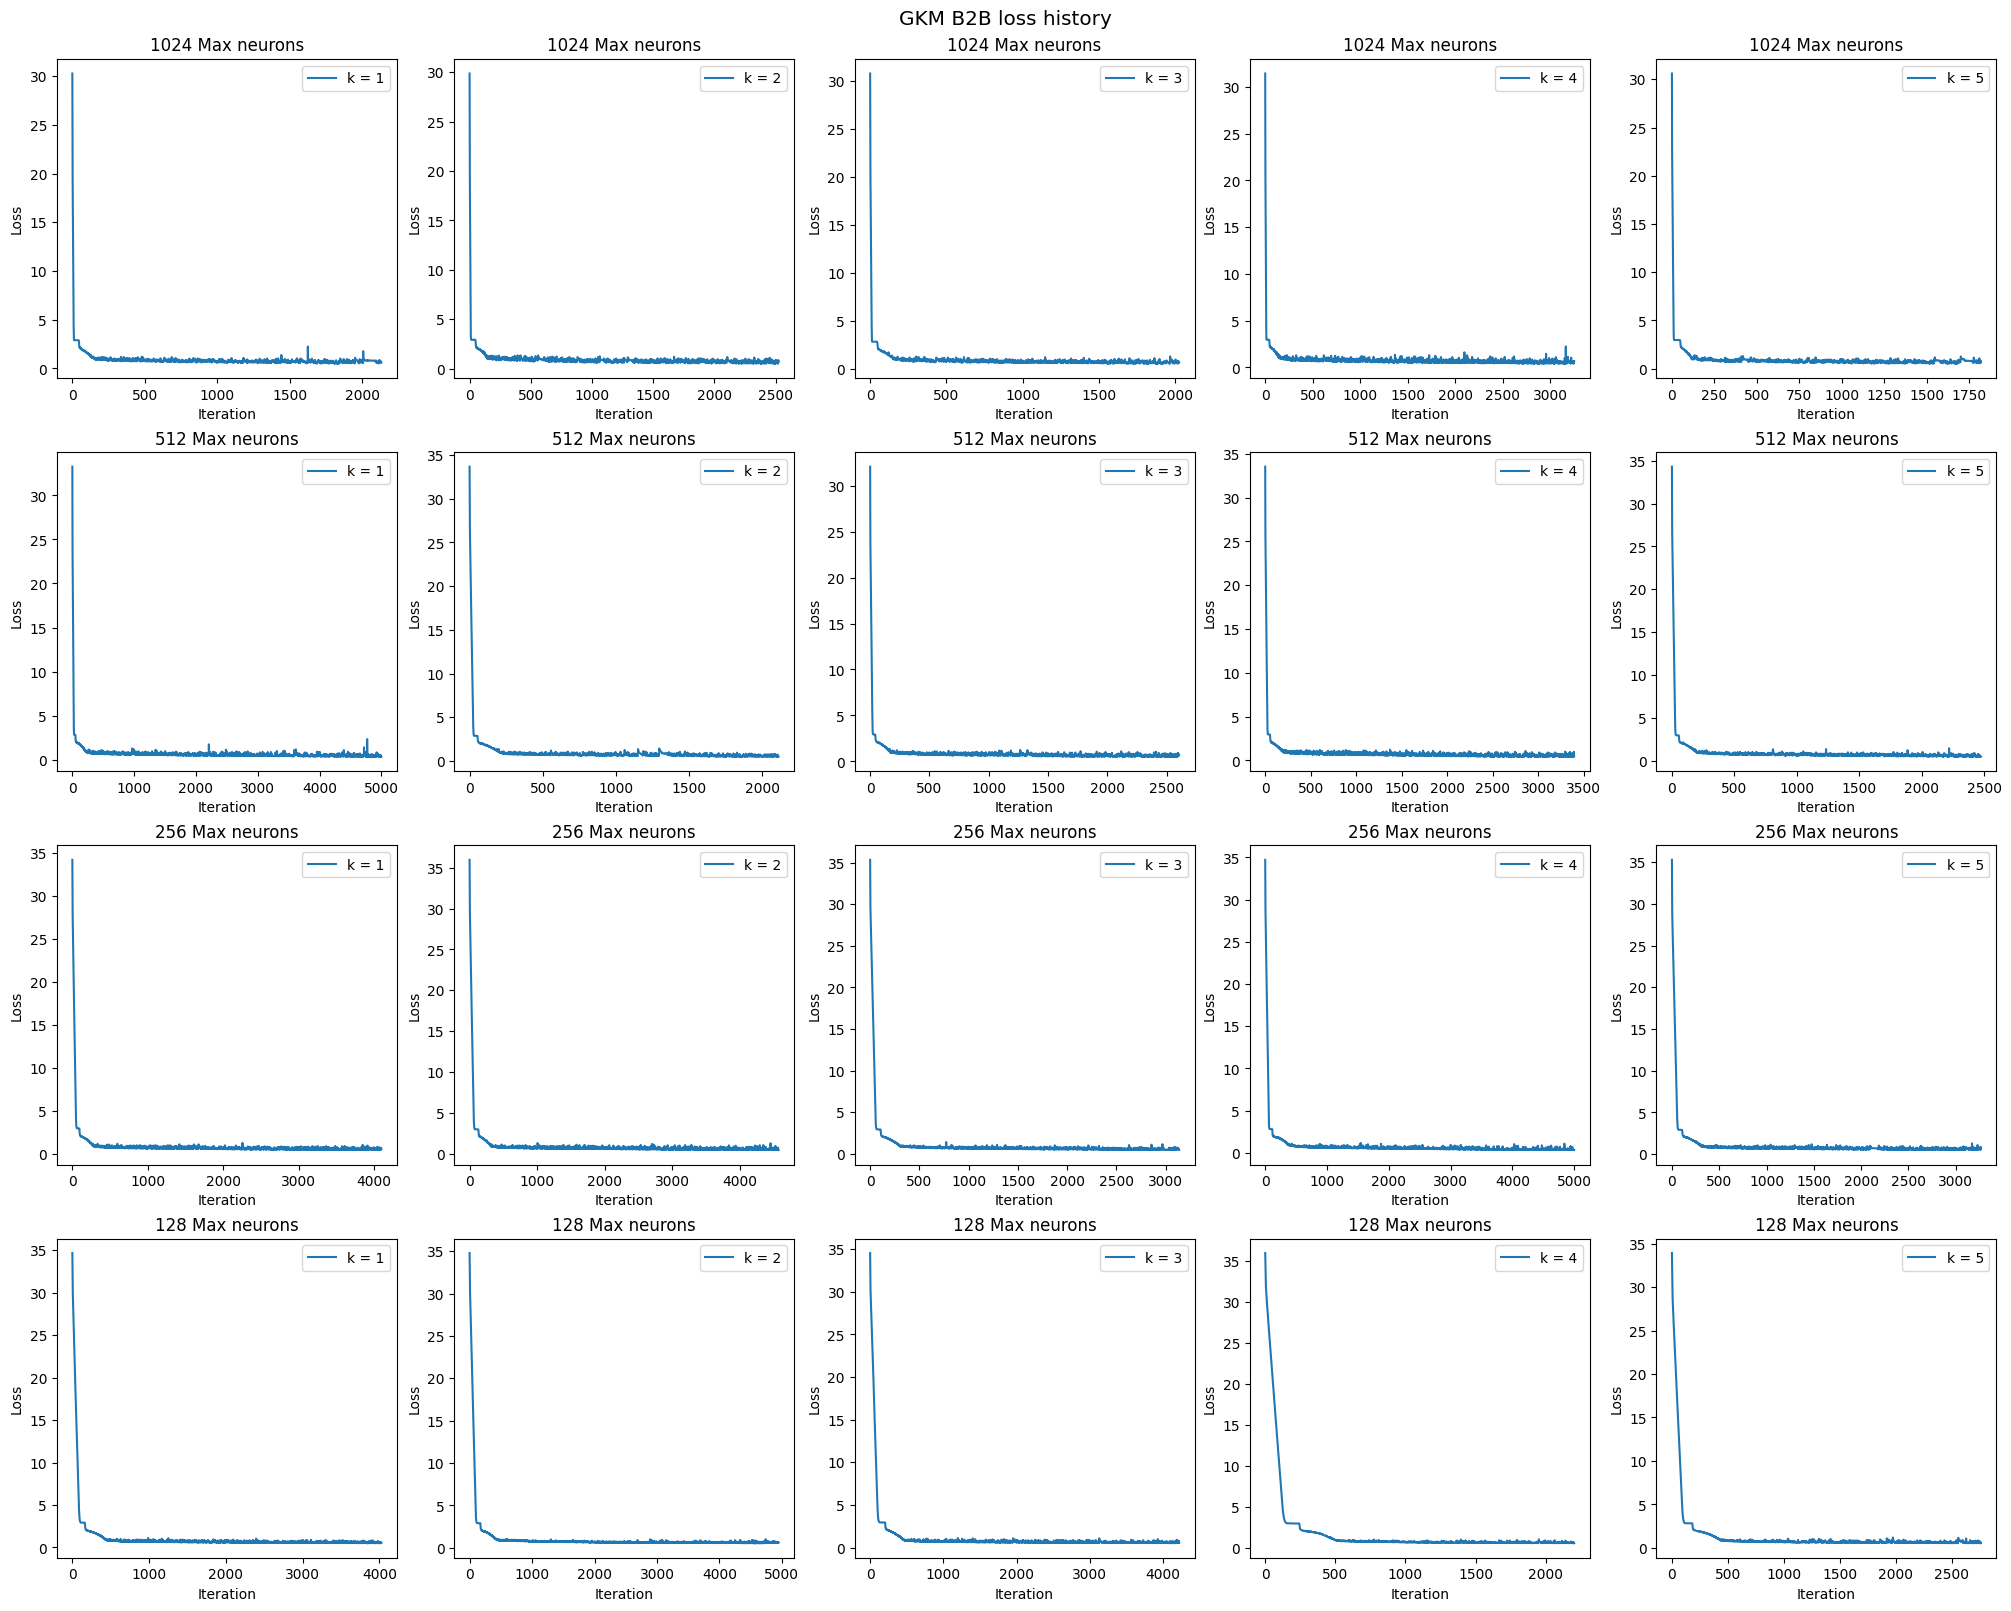

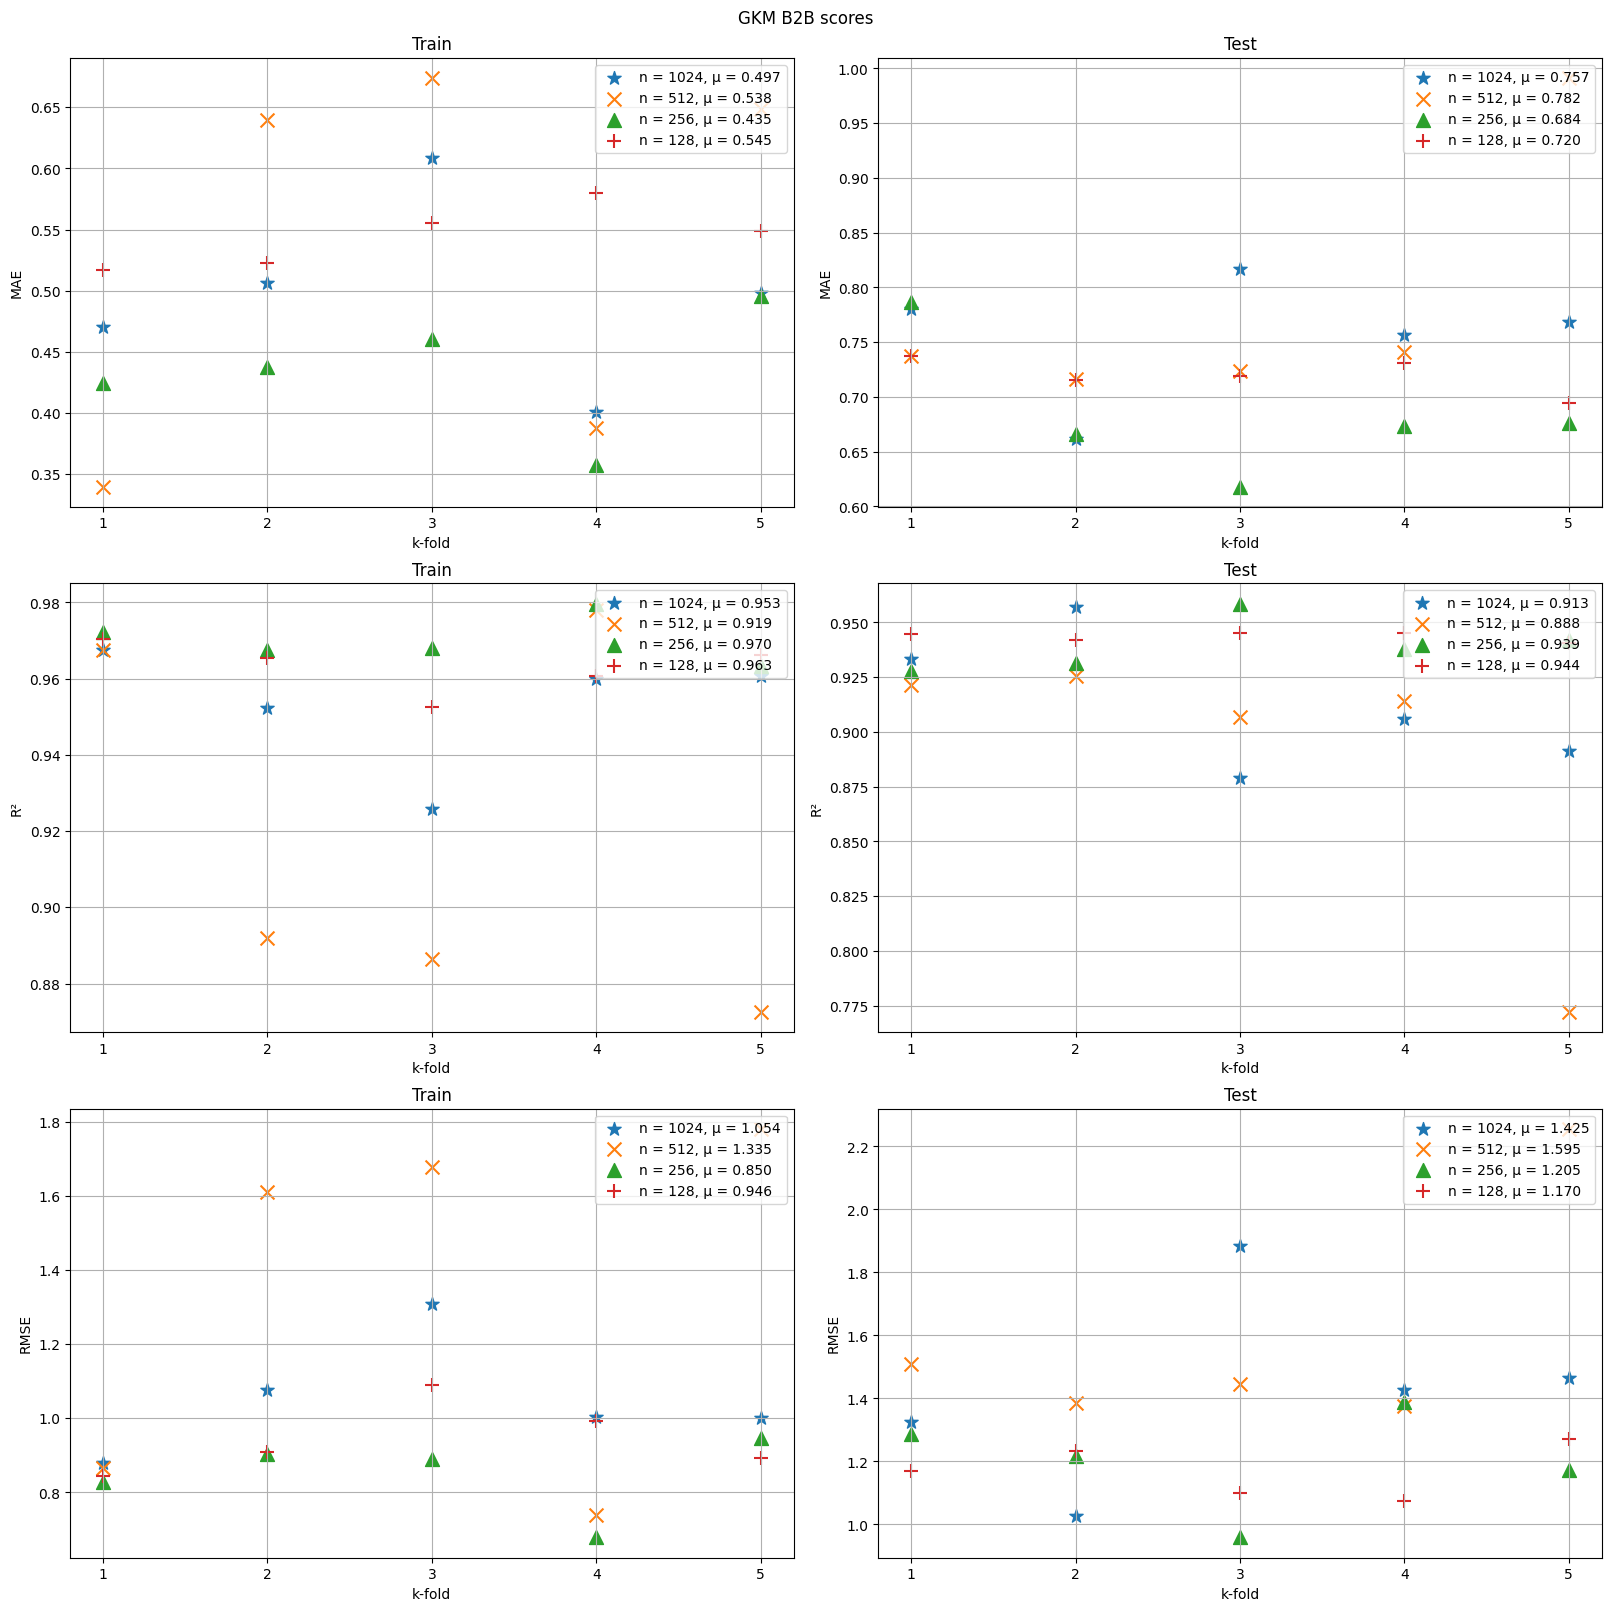

In [28]:
scores = [scores_GKM_1024_B2B, scores_GKM_512_B2B, scores_GKM_256_B2B, scores_GKM_128_B2B]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "GKM B2B")

### Crosvalidación para GKM con fibra óptica a 0dBm variando el número de neuronas por capa

In [29]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_fiber0 = calc_once("scores_GKM_1024_fiber0", test_model, args)

[{'units': 1024, 'activation': 'relu'}, {'units': 512, 'activation': 'tanh'}, {'units': 256, 'activation': 'sigmoid'}]
Needed iterations: 3044
4/4 [==============================] - 0s 2ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 1830
4/4 [==============================] - 0s 2ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 2ms/step
Needed iterations: 4292
4/4 [==============================] - 0s 2ms/step
Time elapsed: 11.67 minutes


In [30]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_fiber0 = calc_once("scores_GKM_512_fiber0", test_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 2892
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 3421
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 2623
4/4 [==============================] - 0s 1ms/step
Time elapsed: 4.64 minutes


In [31]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_fiber0 = calc_once("scores_GKM_256_fiber0", test_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Time elapsed: 3.46 minutes


In [32]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_fiber0 = calc_once("scores_GKM_128_fiber0", test_model, args)

[{'units': 128, 'activation': 'relu'}, {'units': 64, 'activation': 'tanh'}, {'units': 32, 'activation': 'sigmoid'}]
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 912us/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Time elapsed: 2.81 minutes


In [33]:
%store scores_GKM_1024_fiber0
%store scores_GKM_512_fiber0
%store scores_GKM_256_fiber0
%store scores_GKM_128_fiber0

Stored 'scores_GKM_1024_fiber0' (dict)
Stored 'scores_GKM_512_fiber0' (dict)
Stored 'scores_GKM_256_fiber0' (dict)
Stored 'scores_GKM_128_fiber0' (dict)


#### Gráficas de puntajes (GKM con fibra óptica a 0dBm)

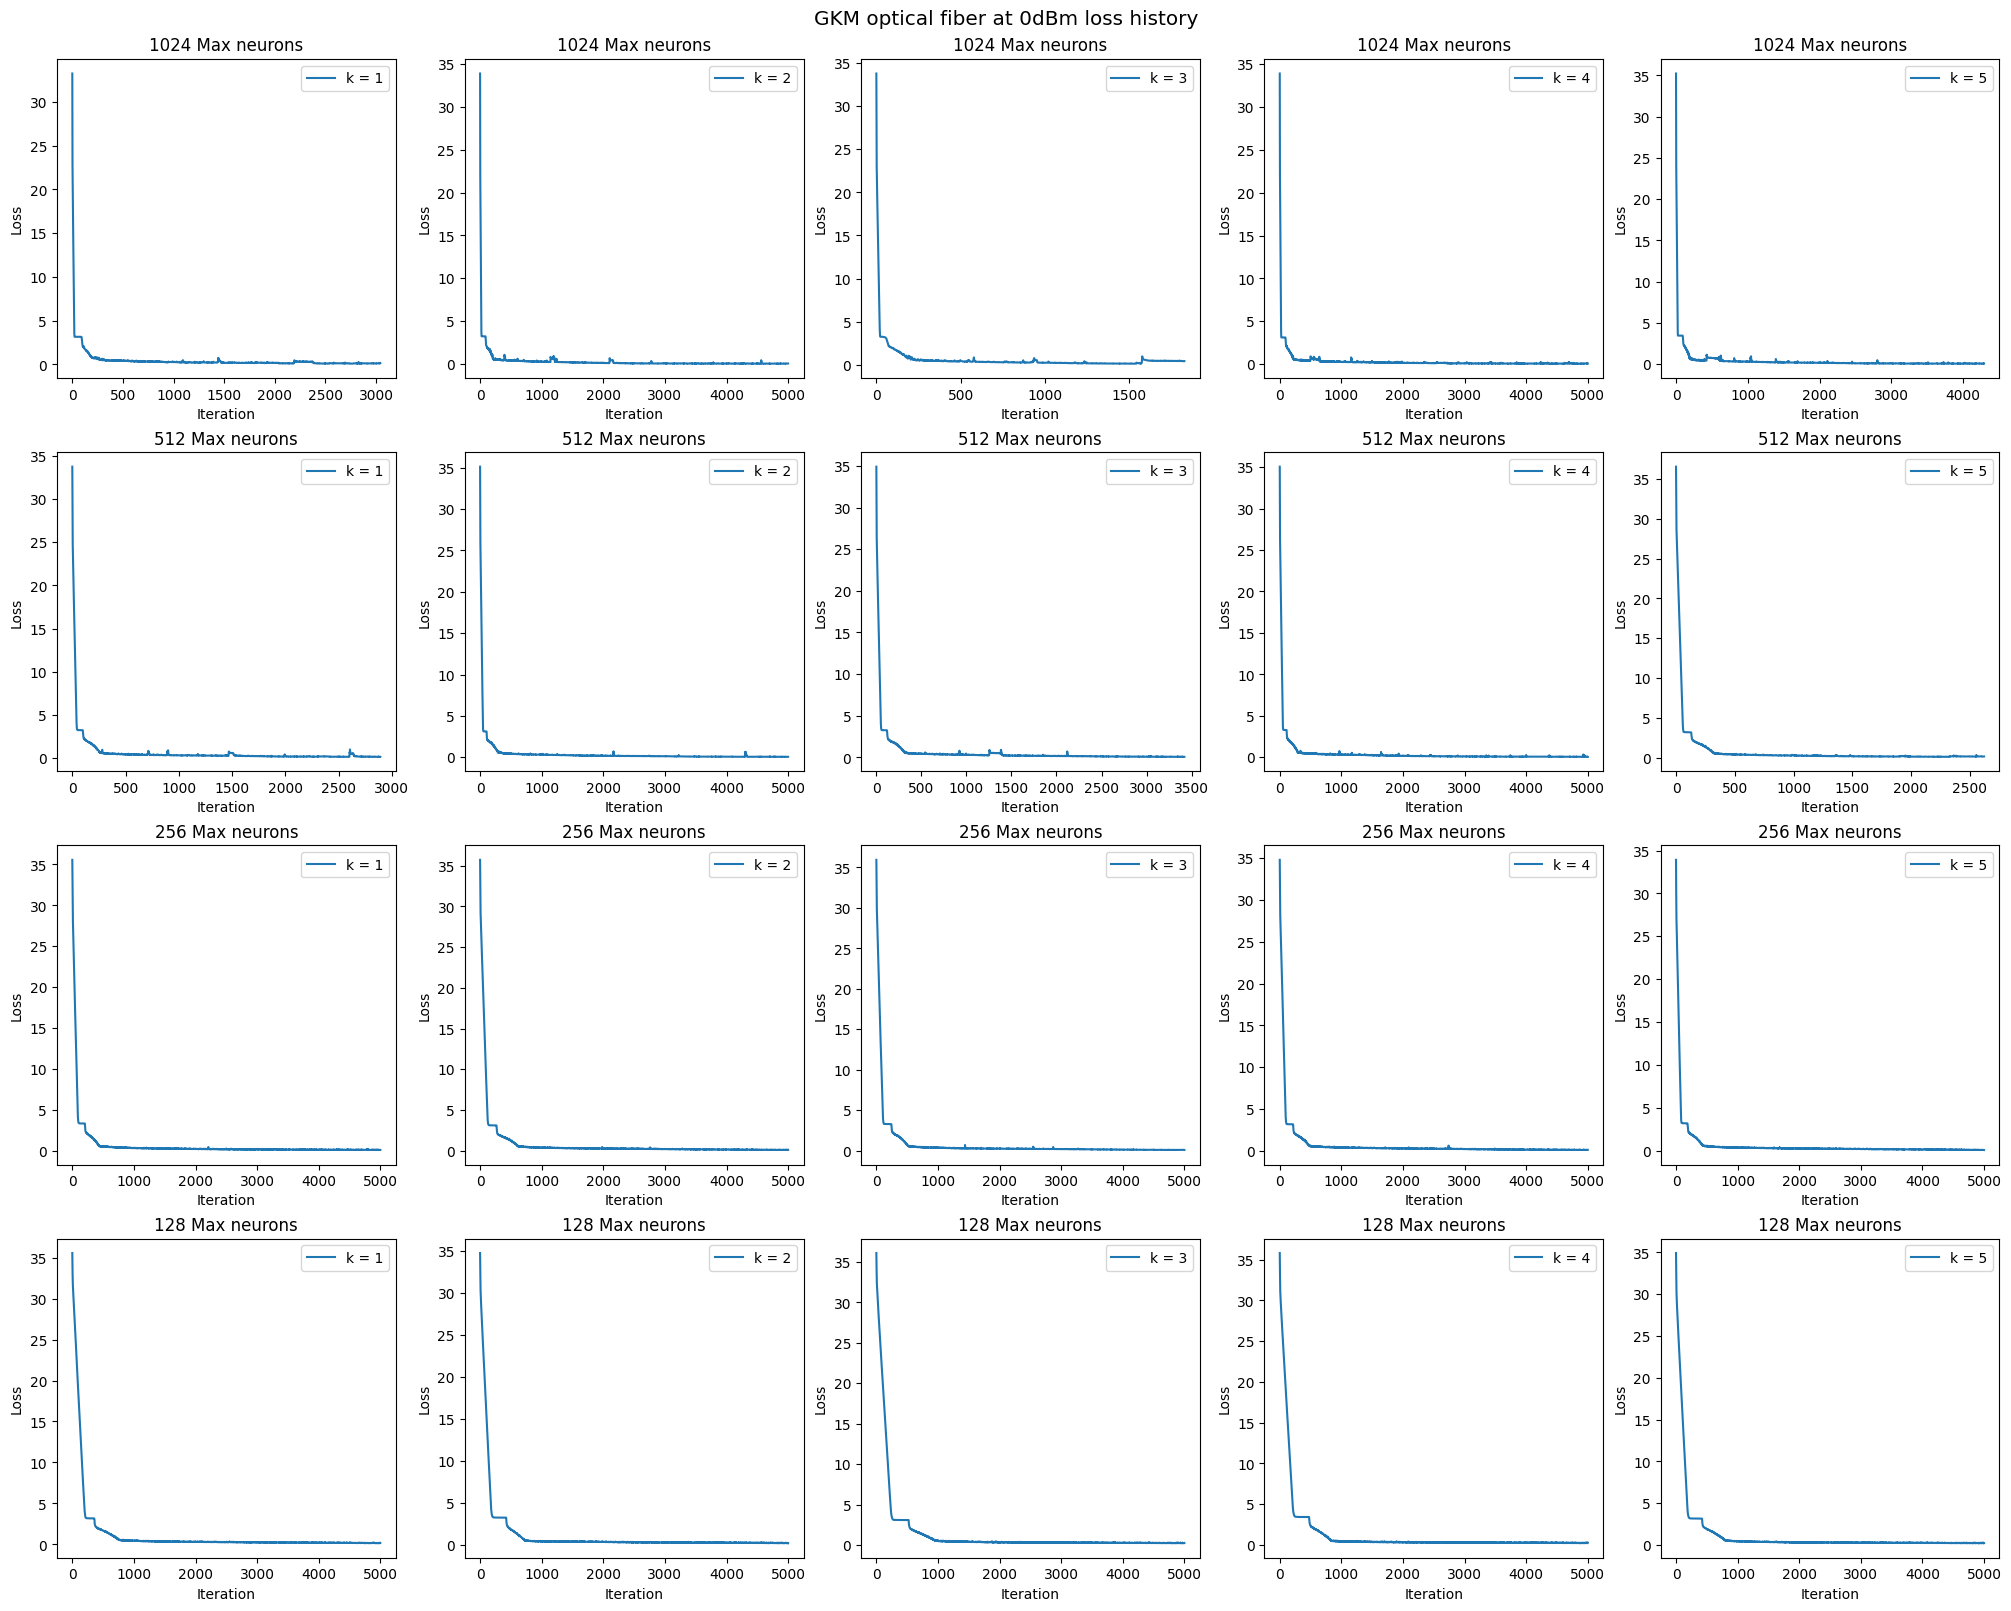

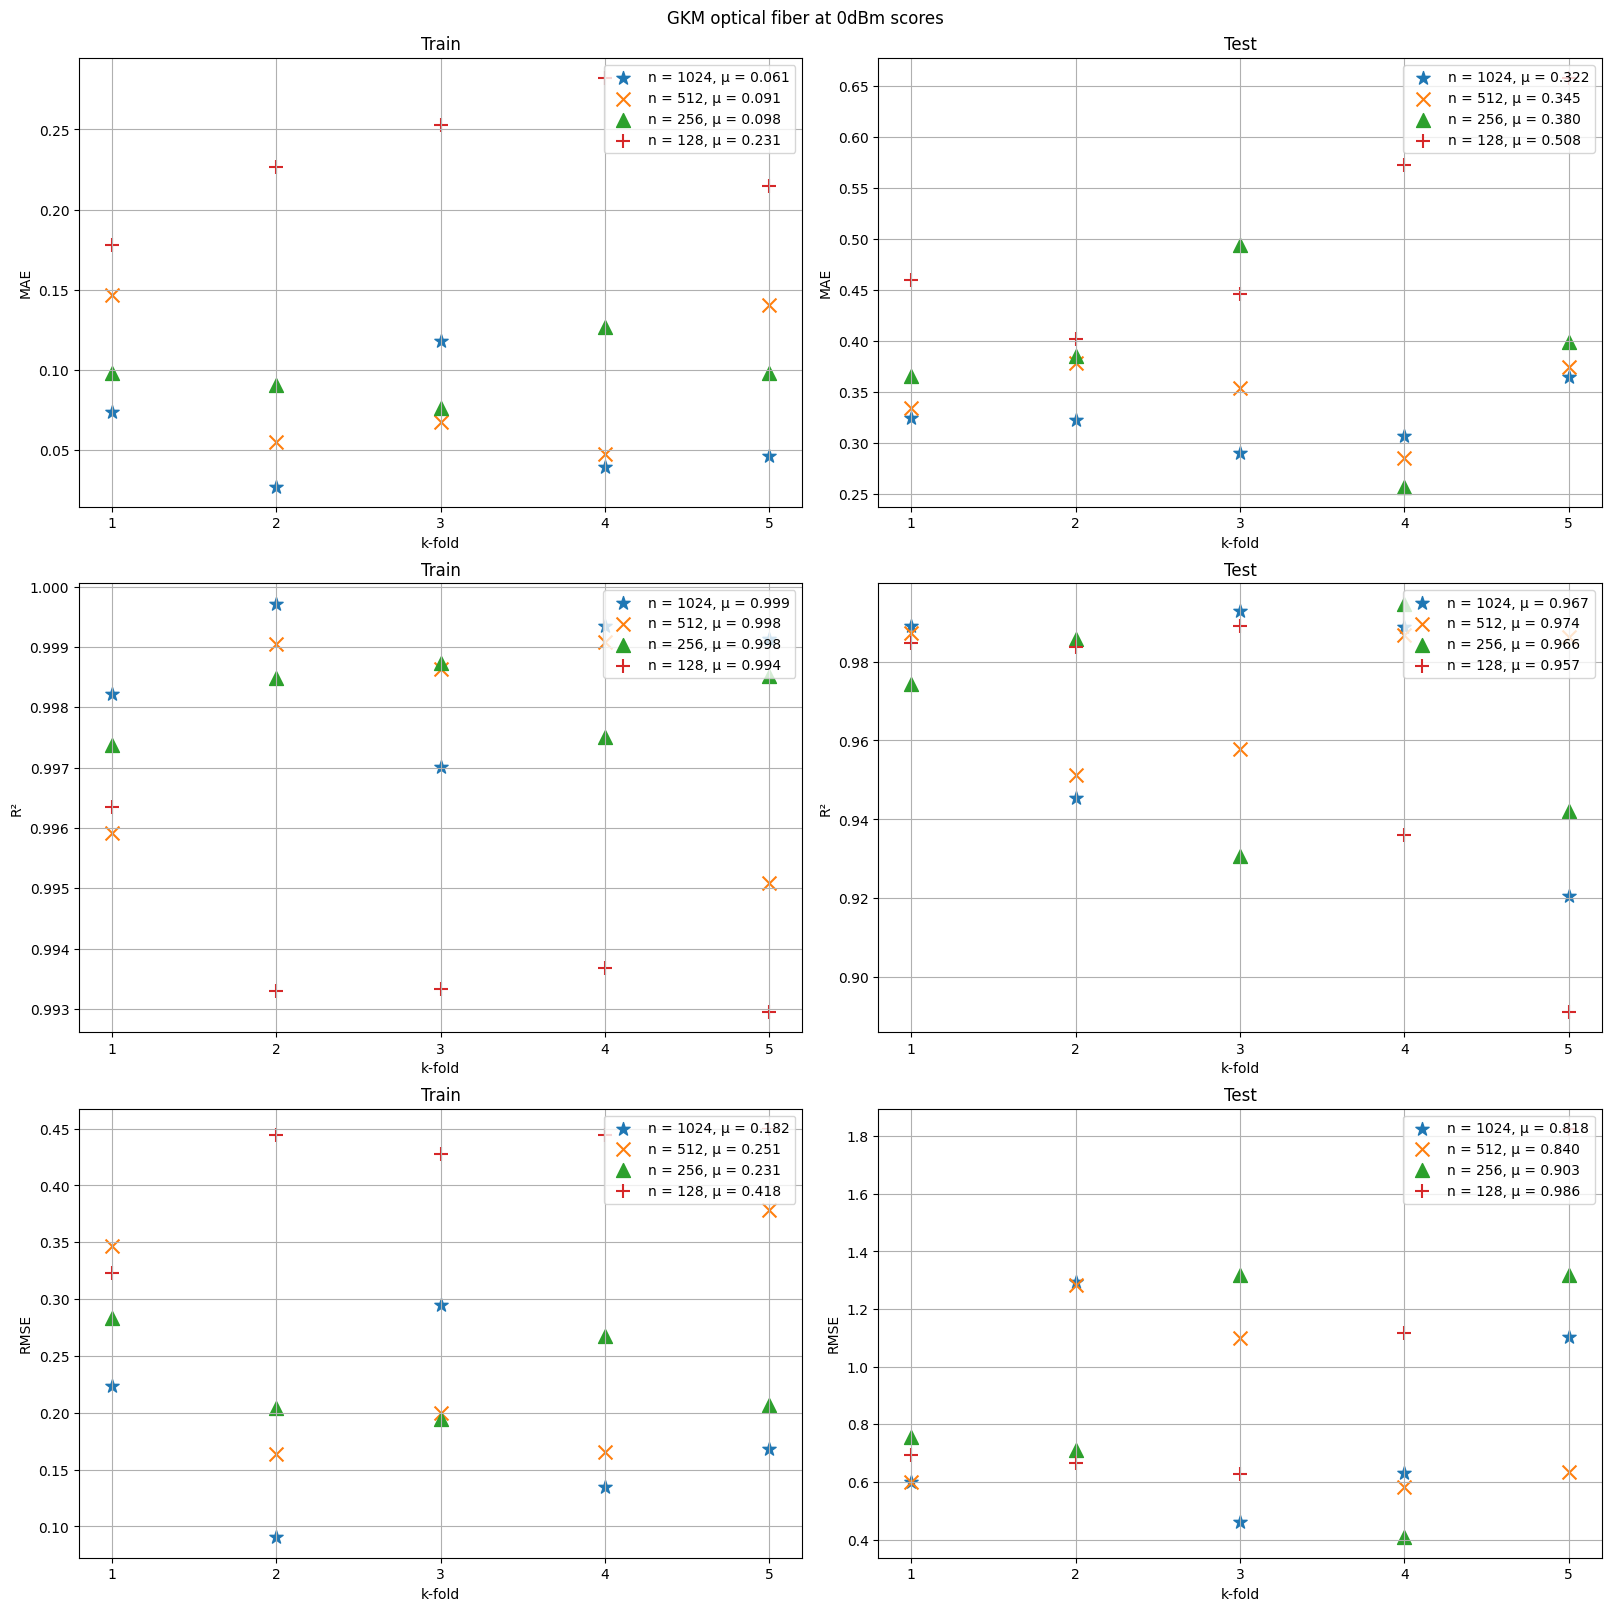

In [34]:
scores = [scores_GKM_1024_fiber0, scores_GKM_512_fiber0, scores_GKM_256_fiber0, scores_GKM_128_fiber0]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "GKM optical fiber at 0dBm")

### Crosvalidación para GKM con fibra óptica a 9dBm variando el número de neuronas por capa

In [43]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_fiber9 = calc_once("scores_GKM_1024_fiber9", test_model, args)

[{'units': 1024, 'activation': 'relu'}, {'units': 512, 'activation': 'tanh'}, {'units': 256, 'activation': 'sigmoid'}]
Needed iterations: 749
6/6 [==============================] - 0s 2ms/step
Needed iterations: 771
6/6 [==============================] - 0s 2ms/step
Needed iterations: 823
6/6 [==============================] - 0s 2ms/step
Needed iterations: 896
6/6 [==============================] - 0s 1ms/step
Needed iterations: 903
6/6 [==============================] - 0s 4ms/step
Time elapsed: 4.47 minutes


In [44]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_fiber9 = calc_once("scores_GKM_512_fiber9", test_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 1863
6/6 [==============================] - 0s 2ms/step
Needed iterations: 1848
6/6 [==============================] - 0s 1ms/step
Needed iterations: 931
6/6 [==============================] - 0s 1ms/step
Needed iterations: 1545
6/6 [==============================] - 0s 1ms/step
Needed iterations: 1275
6/6 [==============================] - 0s 5ms/step
Time elapsed: 3.62 minutes


In [45]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_fiber9 = calc_once("scores_GKM_256_fiber9", test_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 2015
6/6 [==============================] - 0s 1ms/step
Needed iterations: 2856
6/6 [==============================] - 0s 3ms/step
Needed iterations: 2671
6/6 [==============================] - 0s 996us/step
Needed iterations: 2375
6/6 [==============================] - 0s 4ms/step
Needed iterations: 1051
6/6 [==============================] - 0s 2ms/step
Time elapsed: 2.45 minutes


In [46]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_fiber9 = calc_once("scores_GKM_128_fiber9", test_model, args)

[{'units': 128, 'activation': 'relu'}, {'units': 64, 'activation': 'tanh'}, {'units': 32, 'activation': 'sigmoid'}]
Needed iterations: 1946
6/6 [==============================] - 0s 6ms/step
Needed iterations: 1860
6/6 [==============================] - 0s 893us/step
Needed iterations: 1293
6/6 [==============================] - 0s 874us/step
Needed iterations: 1687
6/6 [==============================] - 0s 933us/step
Needed iterations: 2558
6/6 [==============================] - 0s 4ms/step
Time elapsed: 1.63 minutes


In [47]:
%store scores_GKM_1024_fiber9
%store scores_GKM_512_fiber9
%store scores_GKM_256_fiber9
%store scores_GKM_128_fiber9

Stored 'scores_GKM_1024_fiber9' (dict)
Stored 'scores_GKM_512_fiber9' (dict)
Stored 'scores_GKM_256_fiber9' (dict)
Stored 'scores_GKM_128_fiber9' (dict)


#### Gráficas de puntajes (GKM con fibra óptica a 9dBm)

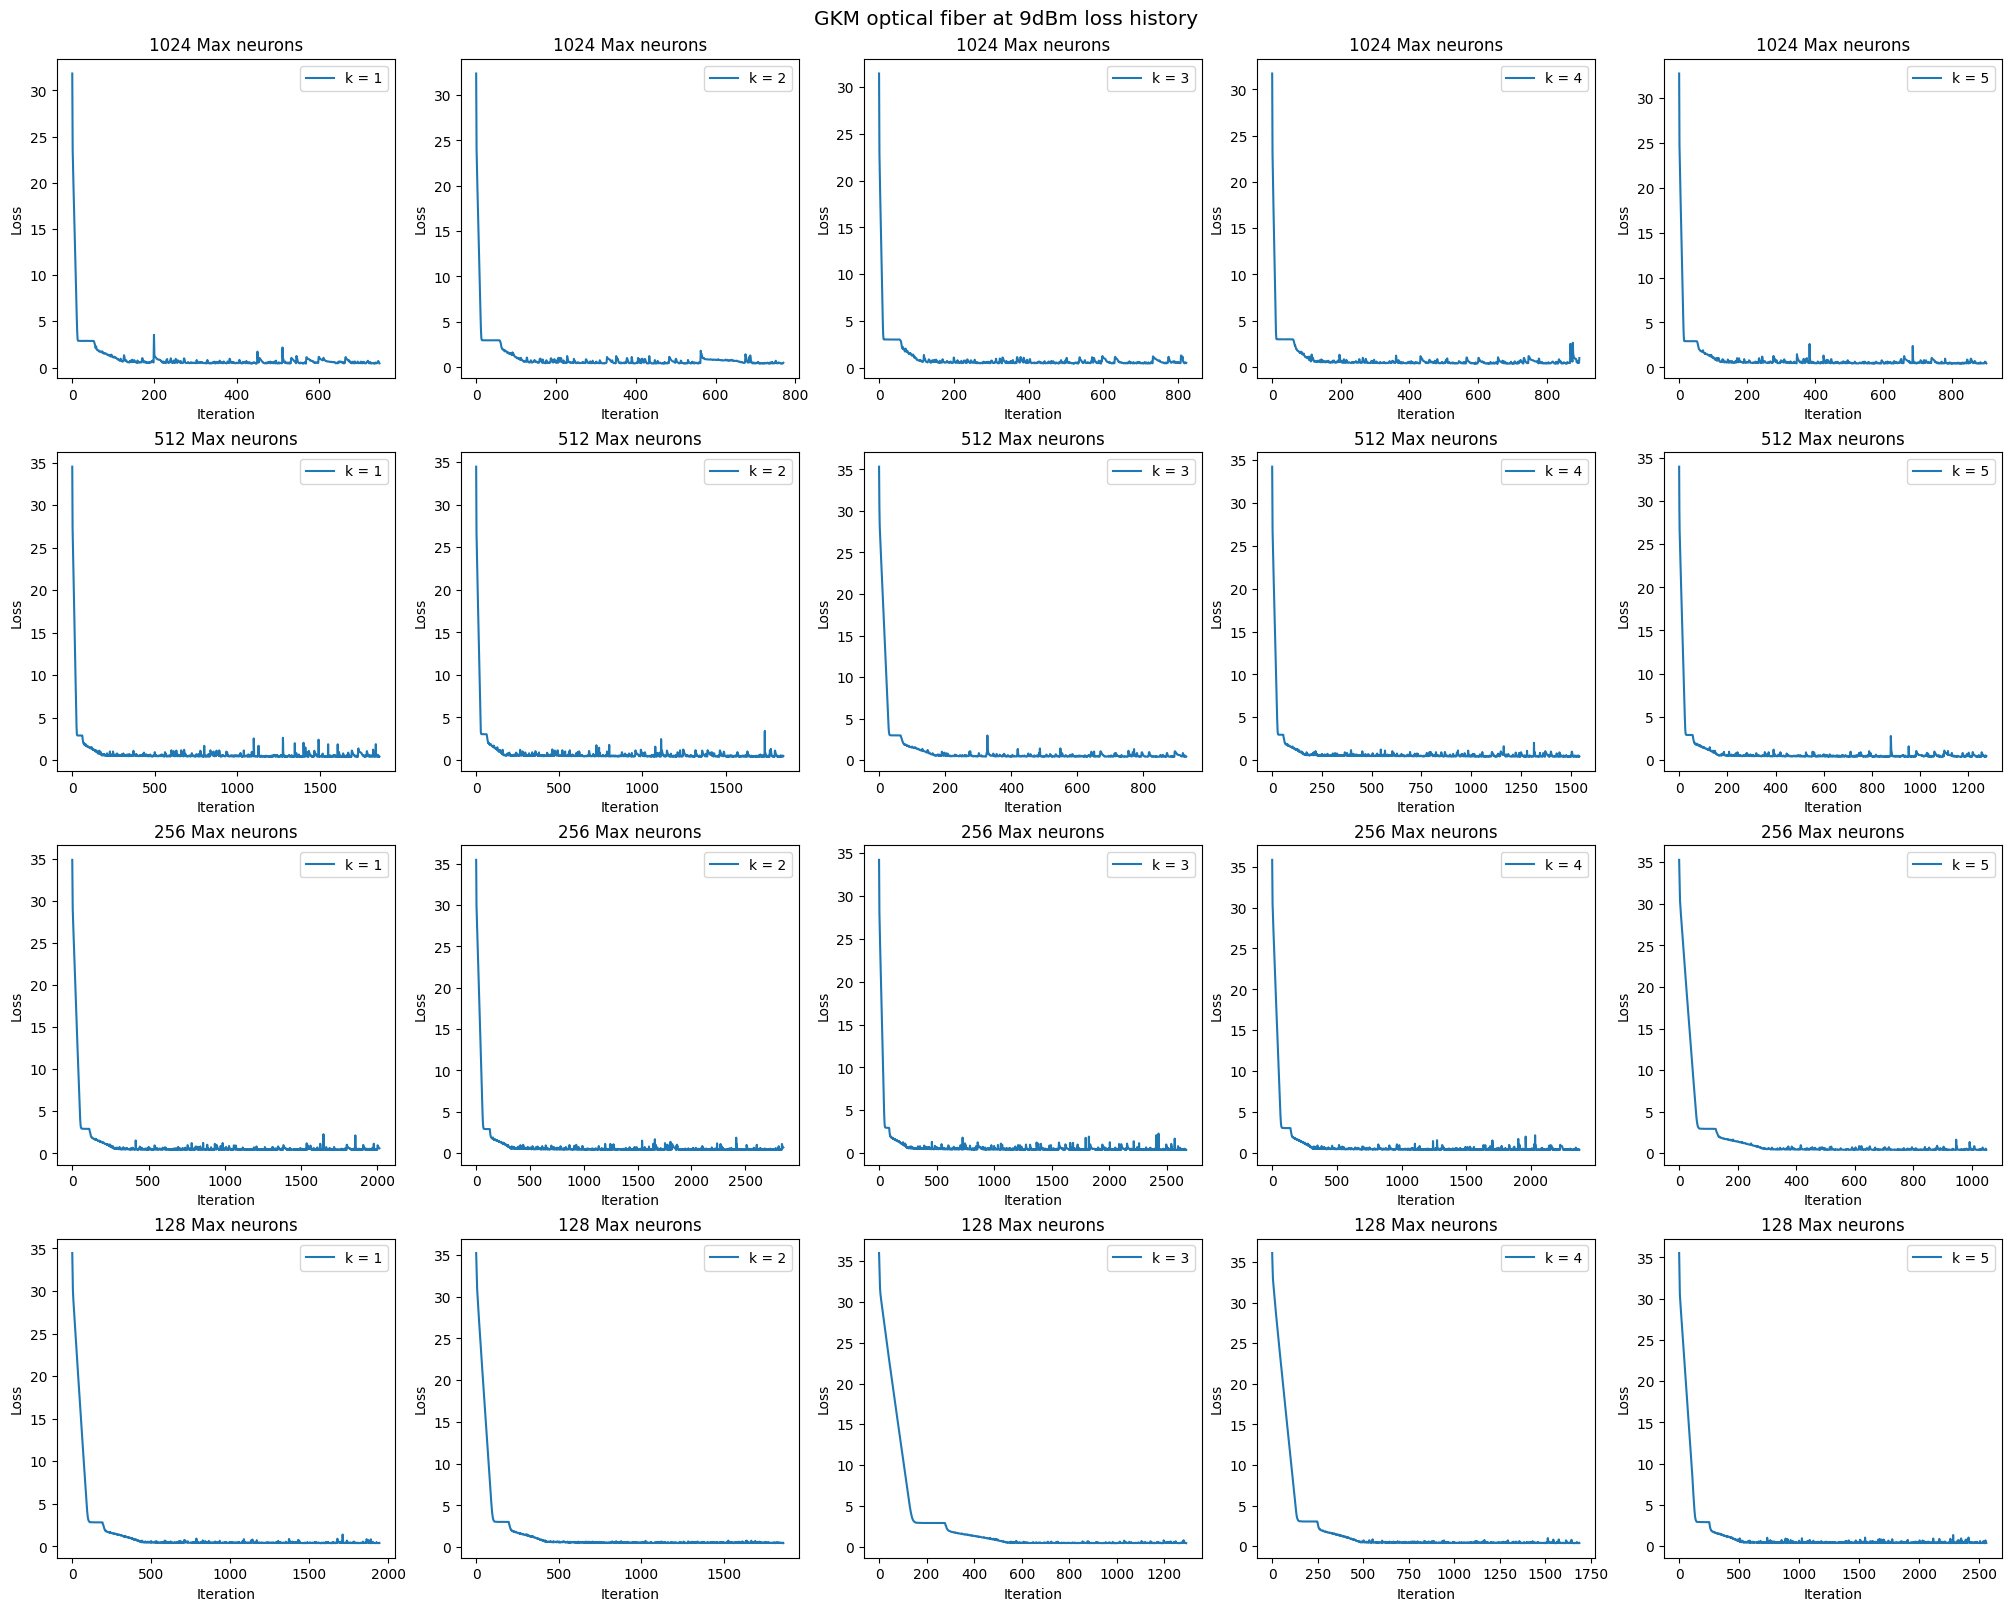

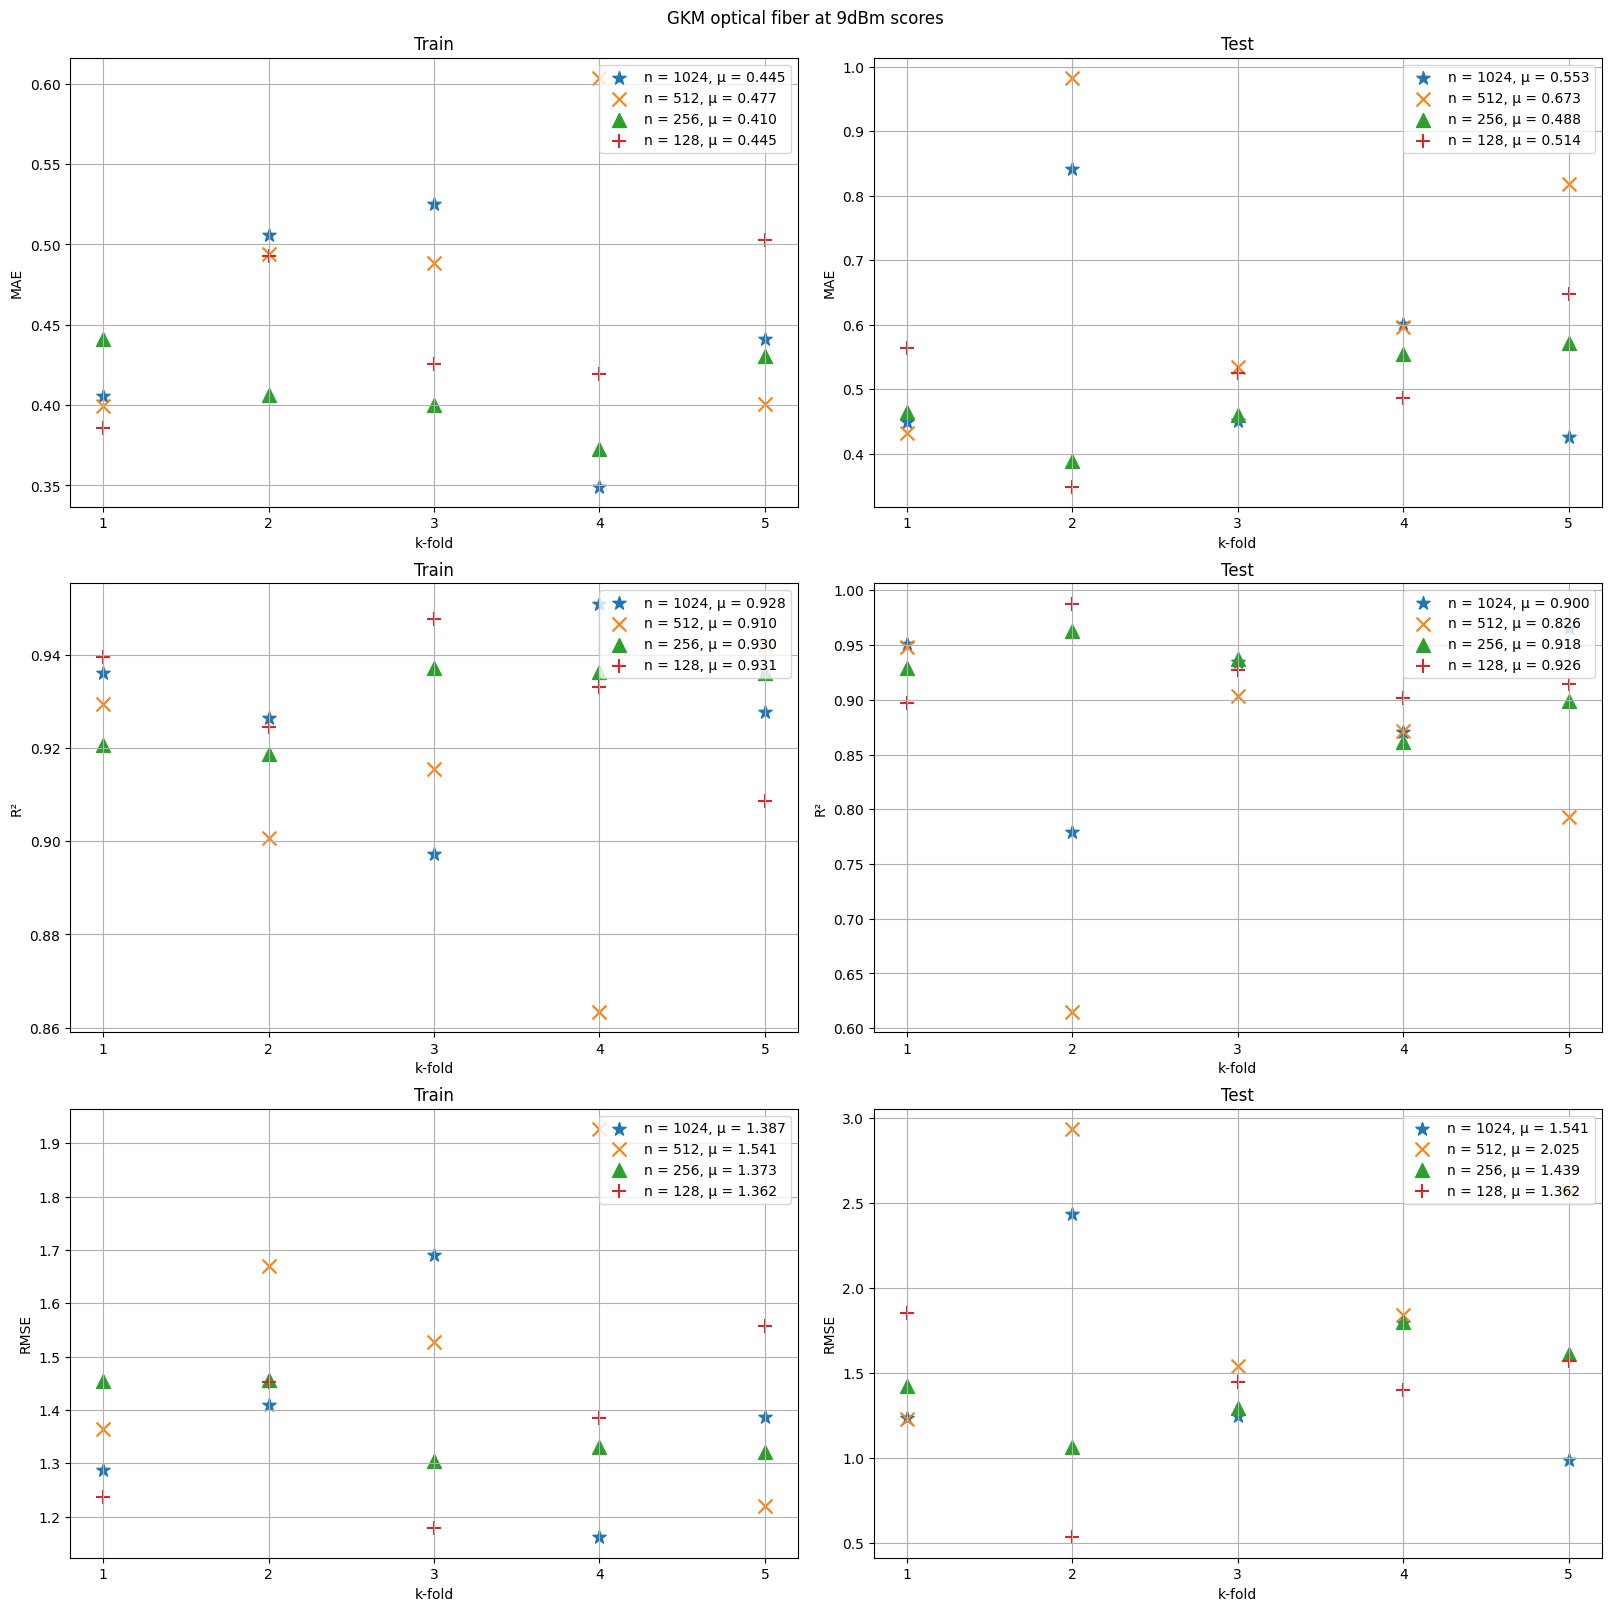

In [48]:
scores = [scores_GKM_1024_fiber9, scores_GKM_512_fiber9, scores_GKM_256_fiber9, scores_GKM_128_fiber9]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "GKM optical fiber at 9dBm")

## FCM y GKM usando 512 máximo número de neuronas y cambiando ReLu por Swish

### Crosvalidación para B2B variando la función ReLu por Swish

In [49]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_B2B = calc_once("scores_FCM_relu_B2B", test_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 5000
7/7 [==============================] - 0s 1ms/step
Needed iterations: 2355
7/7 [==============================] - 0s 1ms/step
Needed iterations: 5000
7/7 [==============================] - 0s 1ms/step
Needed iterations: 5000
7/7 [==============================] - 0s 6ms/step
Needed iterations: 4596
7/7 [==============================] - 0s 1ms/step
Time elapsed: 9.77 minutes


In [50]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_B2B = calc_once("scores_GKM_relu_B2B", test_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 2531
7/7 [==============================] - 0s 1ms/step
Needed iterations: 2809
7/7 [==============================] - 0s 1ms/step
Needed iterations: 5000
7/7 [==============================] - 0s 9ms/step
Needed iterations: 2969
7/7 [==============================] - 0s 980us/step
Needed iterations: 5000
7/7 [==============================] - 0s 1ms/step
Time elapsed: 7.66 minutes


In [51]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_B2B = calc_once("scores_FCM_swish_B2B", test_model, args)

[{'units': 512, 'activation': 'swish'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 4535
7/7 [==============================] - 0s 1ms/step
Needed iterations: 5000
7/7 [==============================] - 0s 1ms/step
Needed iterations: 4553
7/7 [==============================] - 0s 1ms/step
Needed iterations: 2200
7/7 [==============================] - 0s 1ms/step
Needed iterations: 5000
7/7 [==============================] - 0s 1ms/step
Time elapsed: 9.34 minutes


In [52]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_B2B = calc_once("scores_GKM_swish_B2B", test_model, args)

[{'units': 512, 'activation': 'swish'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 5000
7/7 [==============================] - 0s 1ms/step
Needed iterations: 3444
7/7 [==============================] - 0s 1ms/step
Needed iterations: 5000
7/7 [==============================] - 0s 1ms/step
Needed iterations: 5000
7/7 [==============================] - 0s 5ms/step
Needed iterations: 5000
7/7 [==============================] - 0s 2ms/step
Time elapsed: 12.97 minutes


In [53]:
%store scores_FCM_relu_B2B
%store scores_GKM_relu_B2B
%store scores_FCM_swish_B2B
%store scores_GKM_swish_B2B

Stored 'scores_FCM_relu_B2B' (dict)
Stored 'scores_GKM_relu_B2B' (dict)
Stored 'scores_FCM_swish_B2B' (dict)
Stored 'scores_GKM_swish_B2B' (dict)


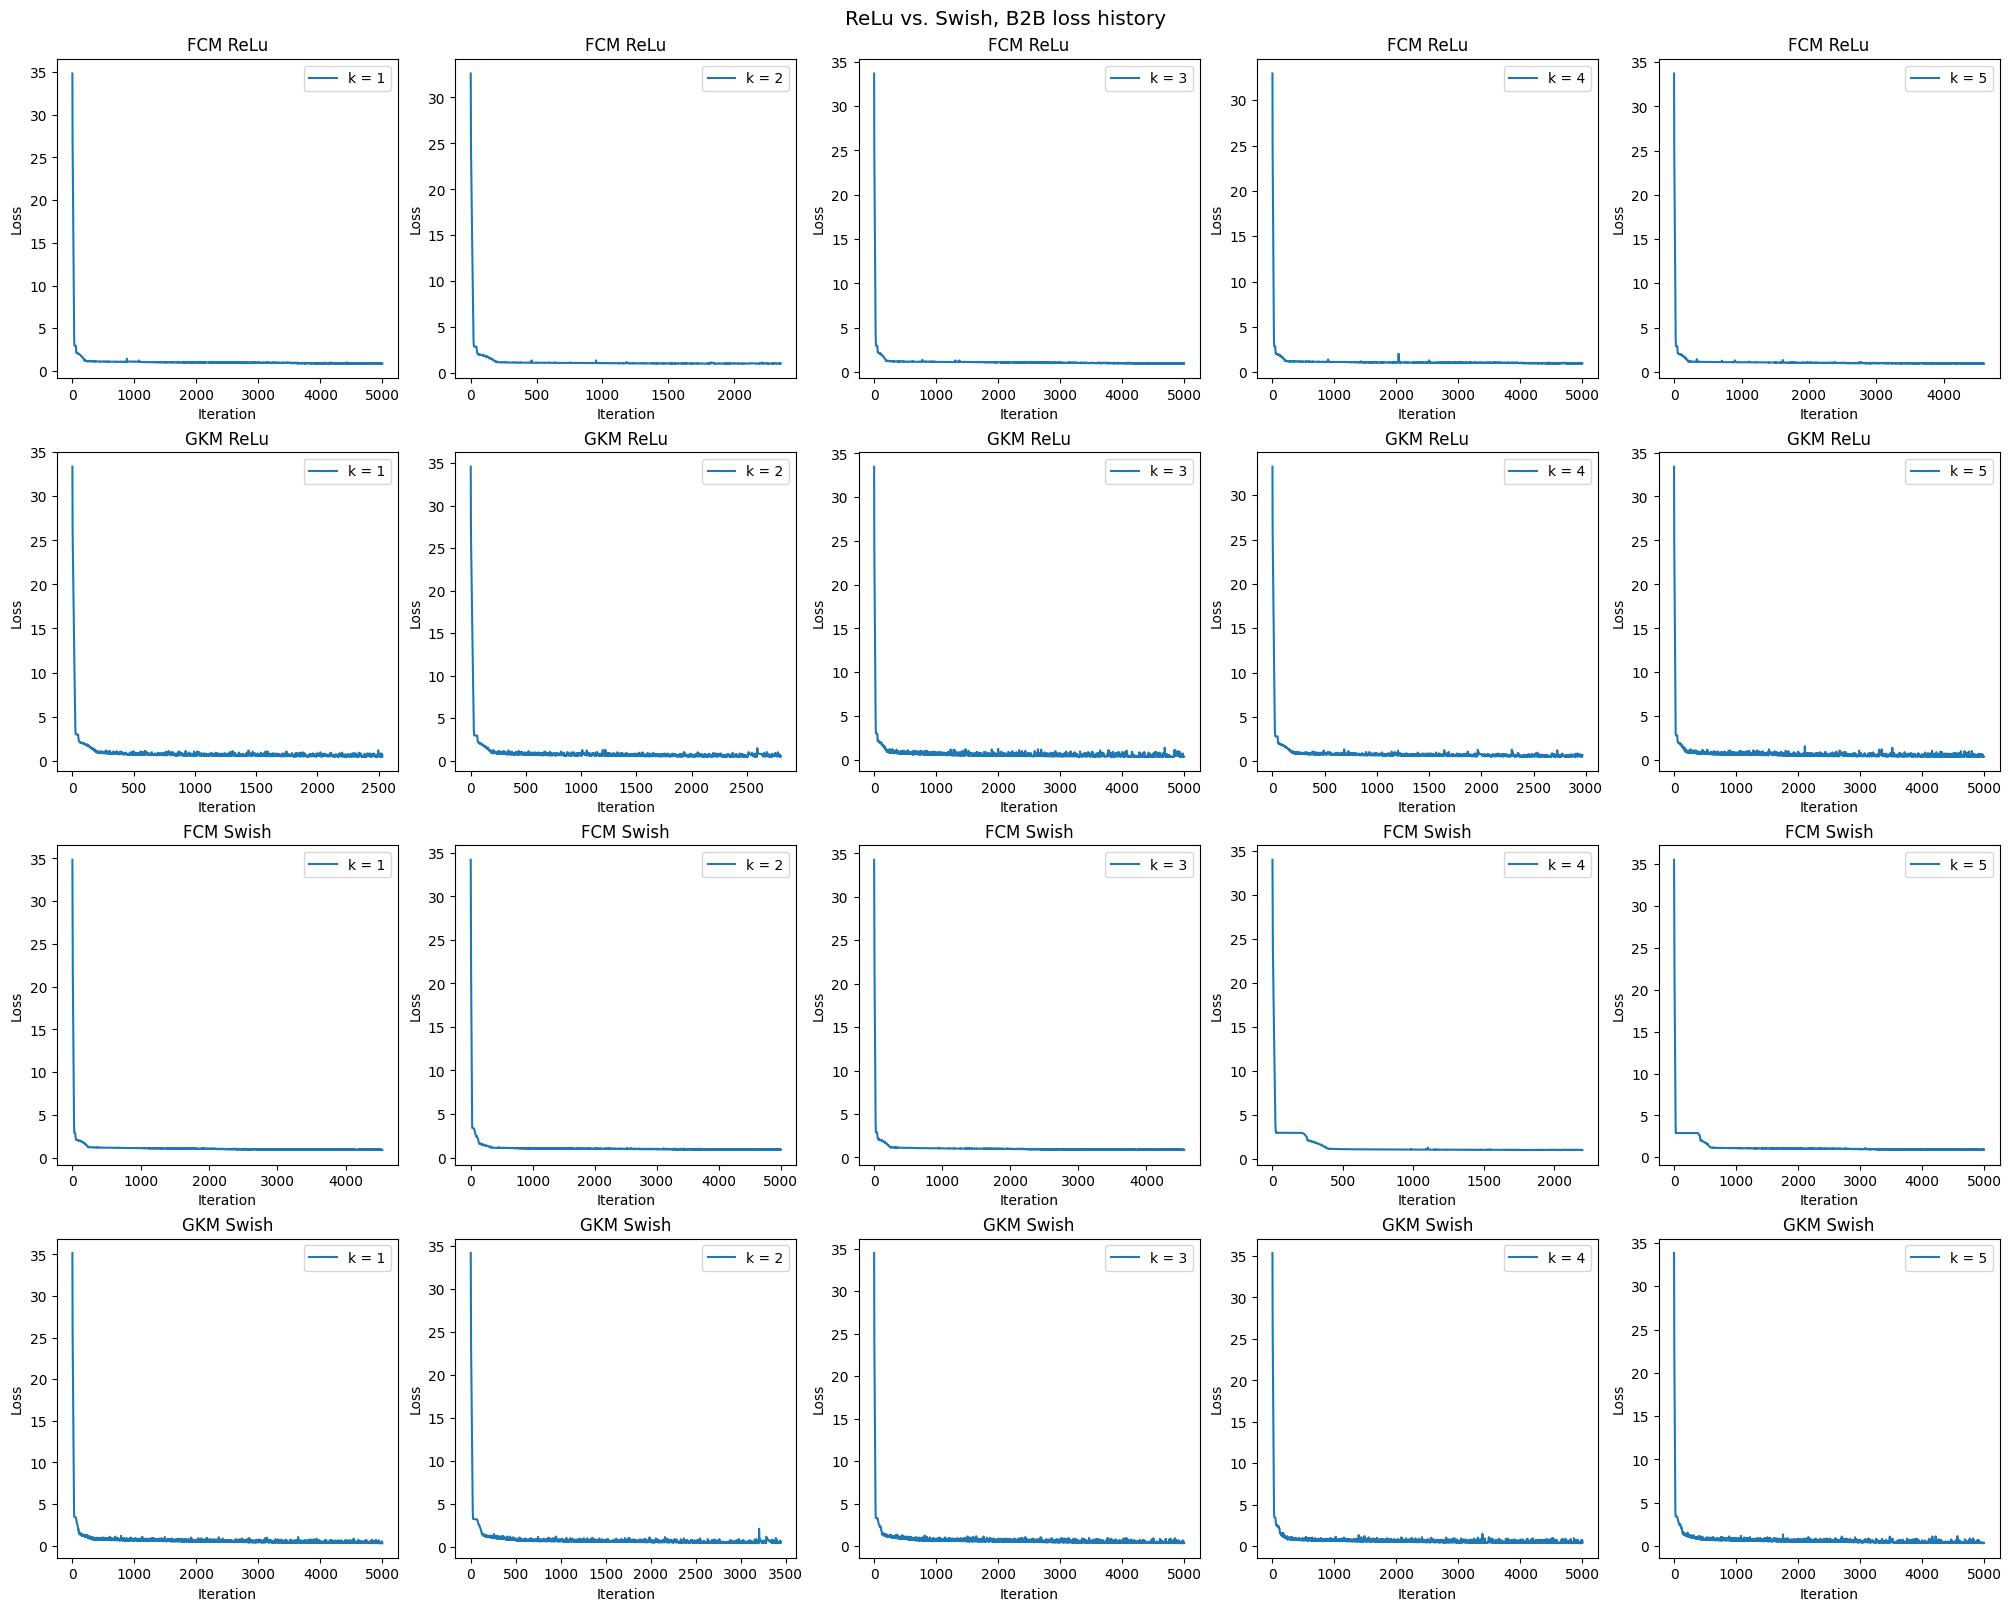

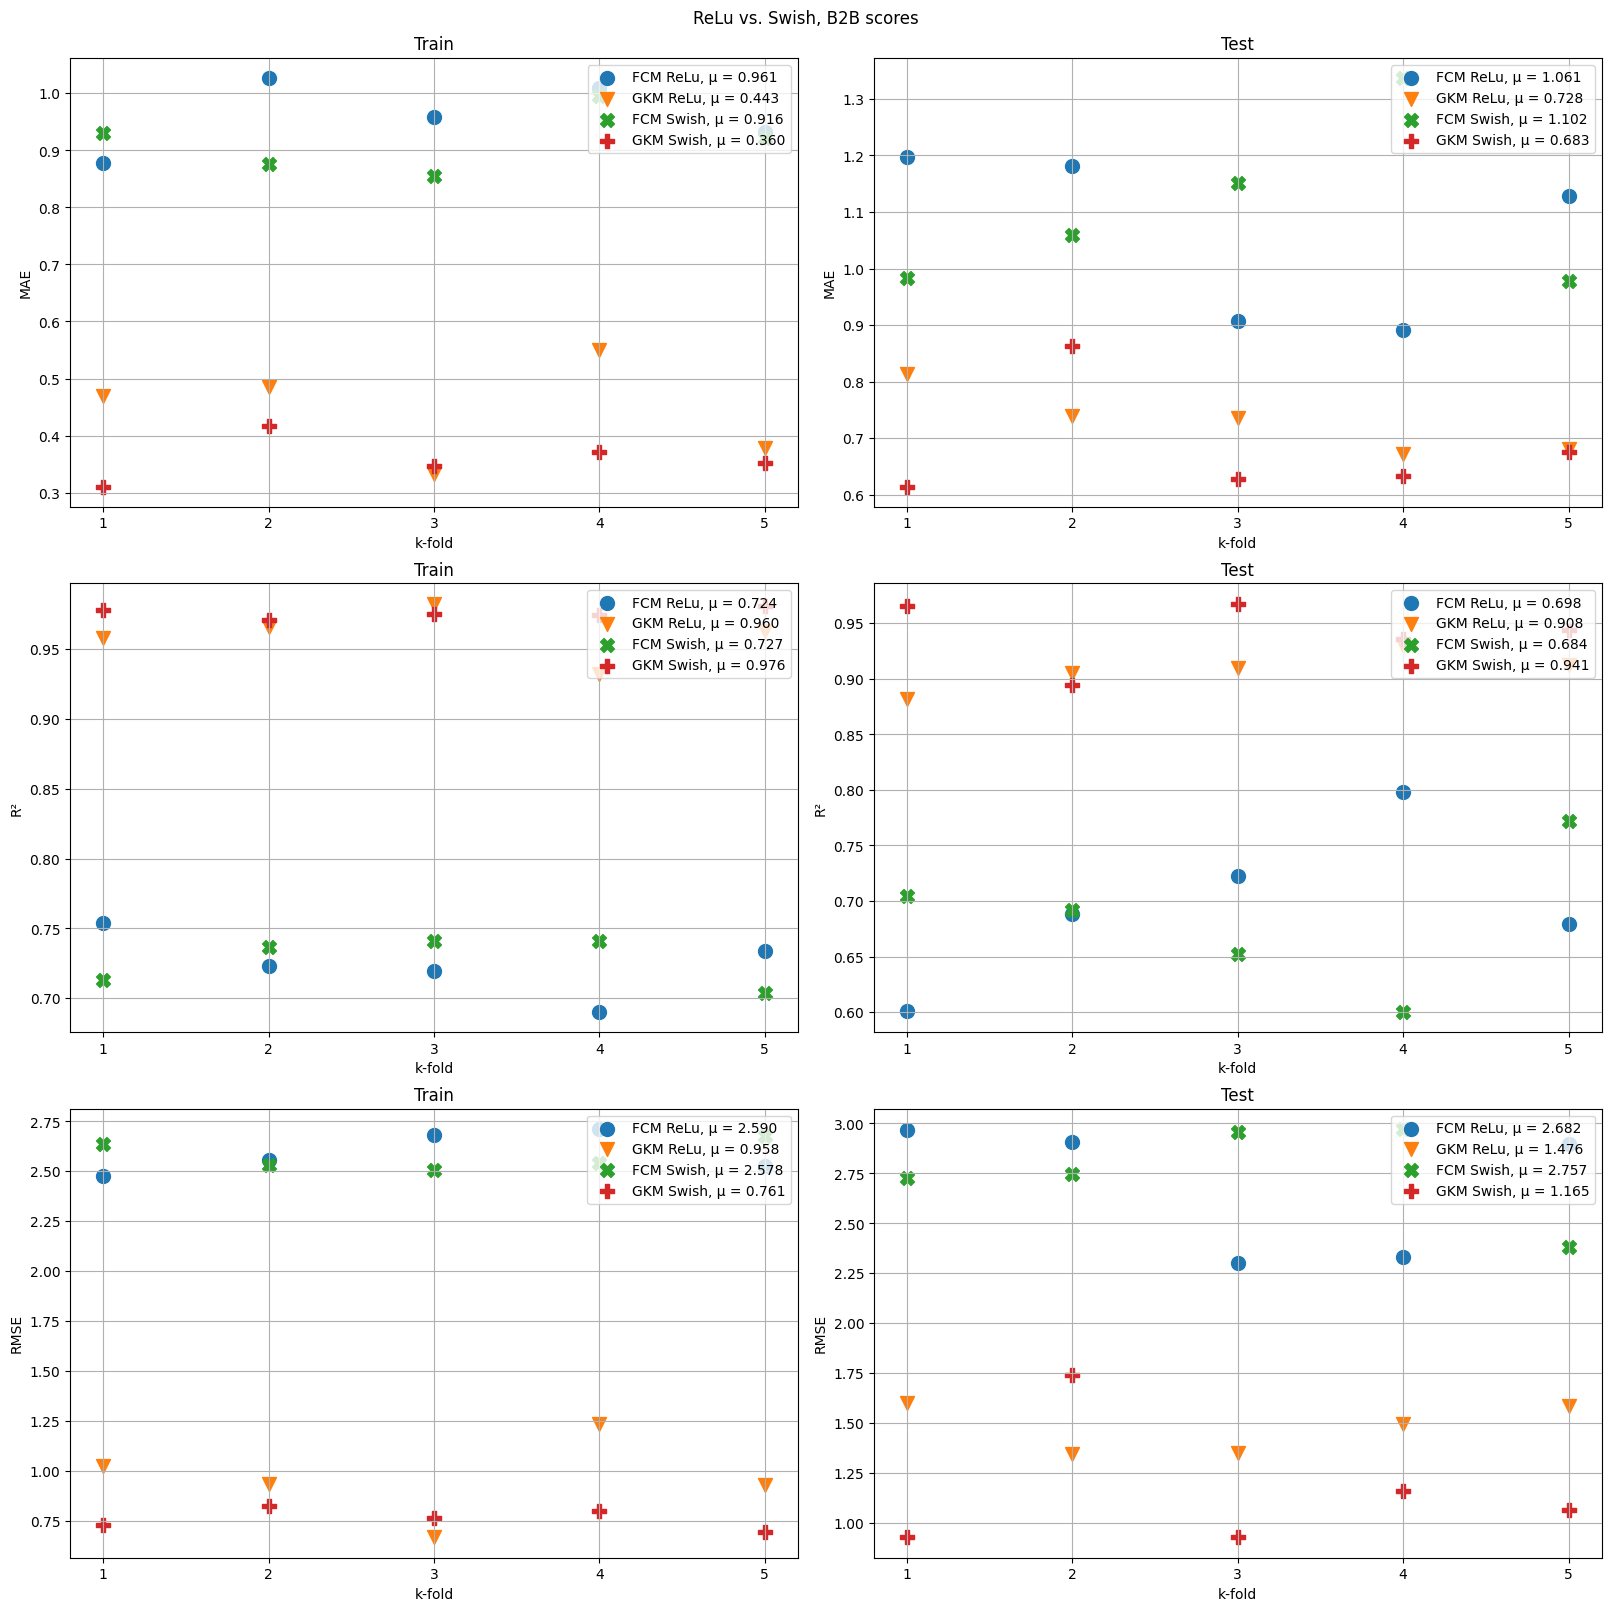

In [54]:
scores = [scores_FCM_relu_B2B, scores_GKM_relu_B2B, scores_FCM_swish_B2B, scores_GKM_swish_B2B]
plot_activations_scores(scores, "ReLu vs. Swish, B2B")

### Crosvalidación para fibra óptica a 0dBm variando la función ReLu por Swish

In [55]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_fiber0 = calc_once("scores_FCM_relu_fiber0", test_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 4076
4/4 [==============================] - 0s 2ms/step
Needed iterations: 2224
4/4 [==============================] - 0s 1ms/step
Needed iterations: 2232
4/4 [==============================] - 0s 1ms/step
Needed iterations: 4479
4/4 [==============================] - 0s 1ms/step
Needed iterations: 3638
4/4 [==============================] - 0s 2ms/step
Time elapsed: 4.33 minutes


In [56]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_fiber0 = calc_once("scores_GKM_relu_fiber0", test_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 2ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 4542
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Time elapsed: 7.01 minutes


In [57]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_fiber0 = calc_once("scores_FCM_swish_fiber0", test_model, args)

[{'units': 512, 'activation': 'swish'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 5000
4/4 [==============================] - 0s 2ms/step
Needed iterations: 3730
4/4 [==============================] - 0s 7ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 2ms/step
Needed iterations: 4432
4/4 [==============================] - 0s 1ms/step
Needed iterations: 3572
4/4 [==============================] - 0s 1ms/step
Time elapsed: 5.70 minutes


In [58]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_fiber0 = calc_once("scores_GKM_swish_fiber0", test_model, args)

[{'units': 512, 'activation': 'swish'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 11ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 5000
4/4 [==============================] - 0s 6ms/step
Time elapsed: 6.09 minutes


In [59]:
%store scores_FCM_relu_fiber0
%store scores_GKM_relu_fiber0
%store scores_FCM_swish_fiber0
%store scores_GKM_swish_fiber0

Stored 'scores_FCM_relu_fiber0' (dict)
Stored 'scores_GKM_relu_fiber0' (dict)
Stored 'scores_FCM_swish_fiber0' (dict)
Stored 'scores_GKM_swish_fiber0' (dict)


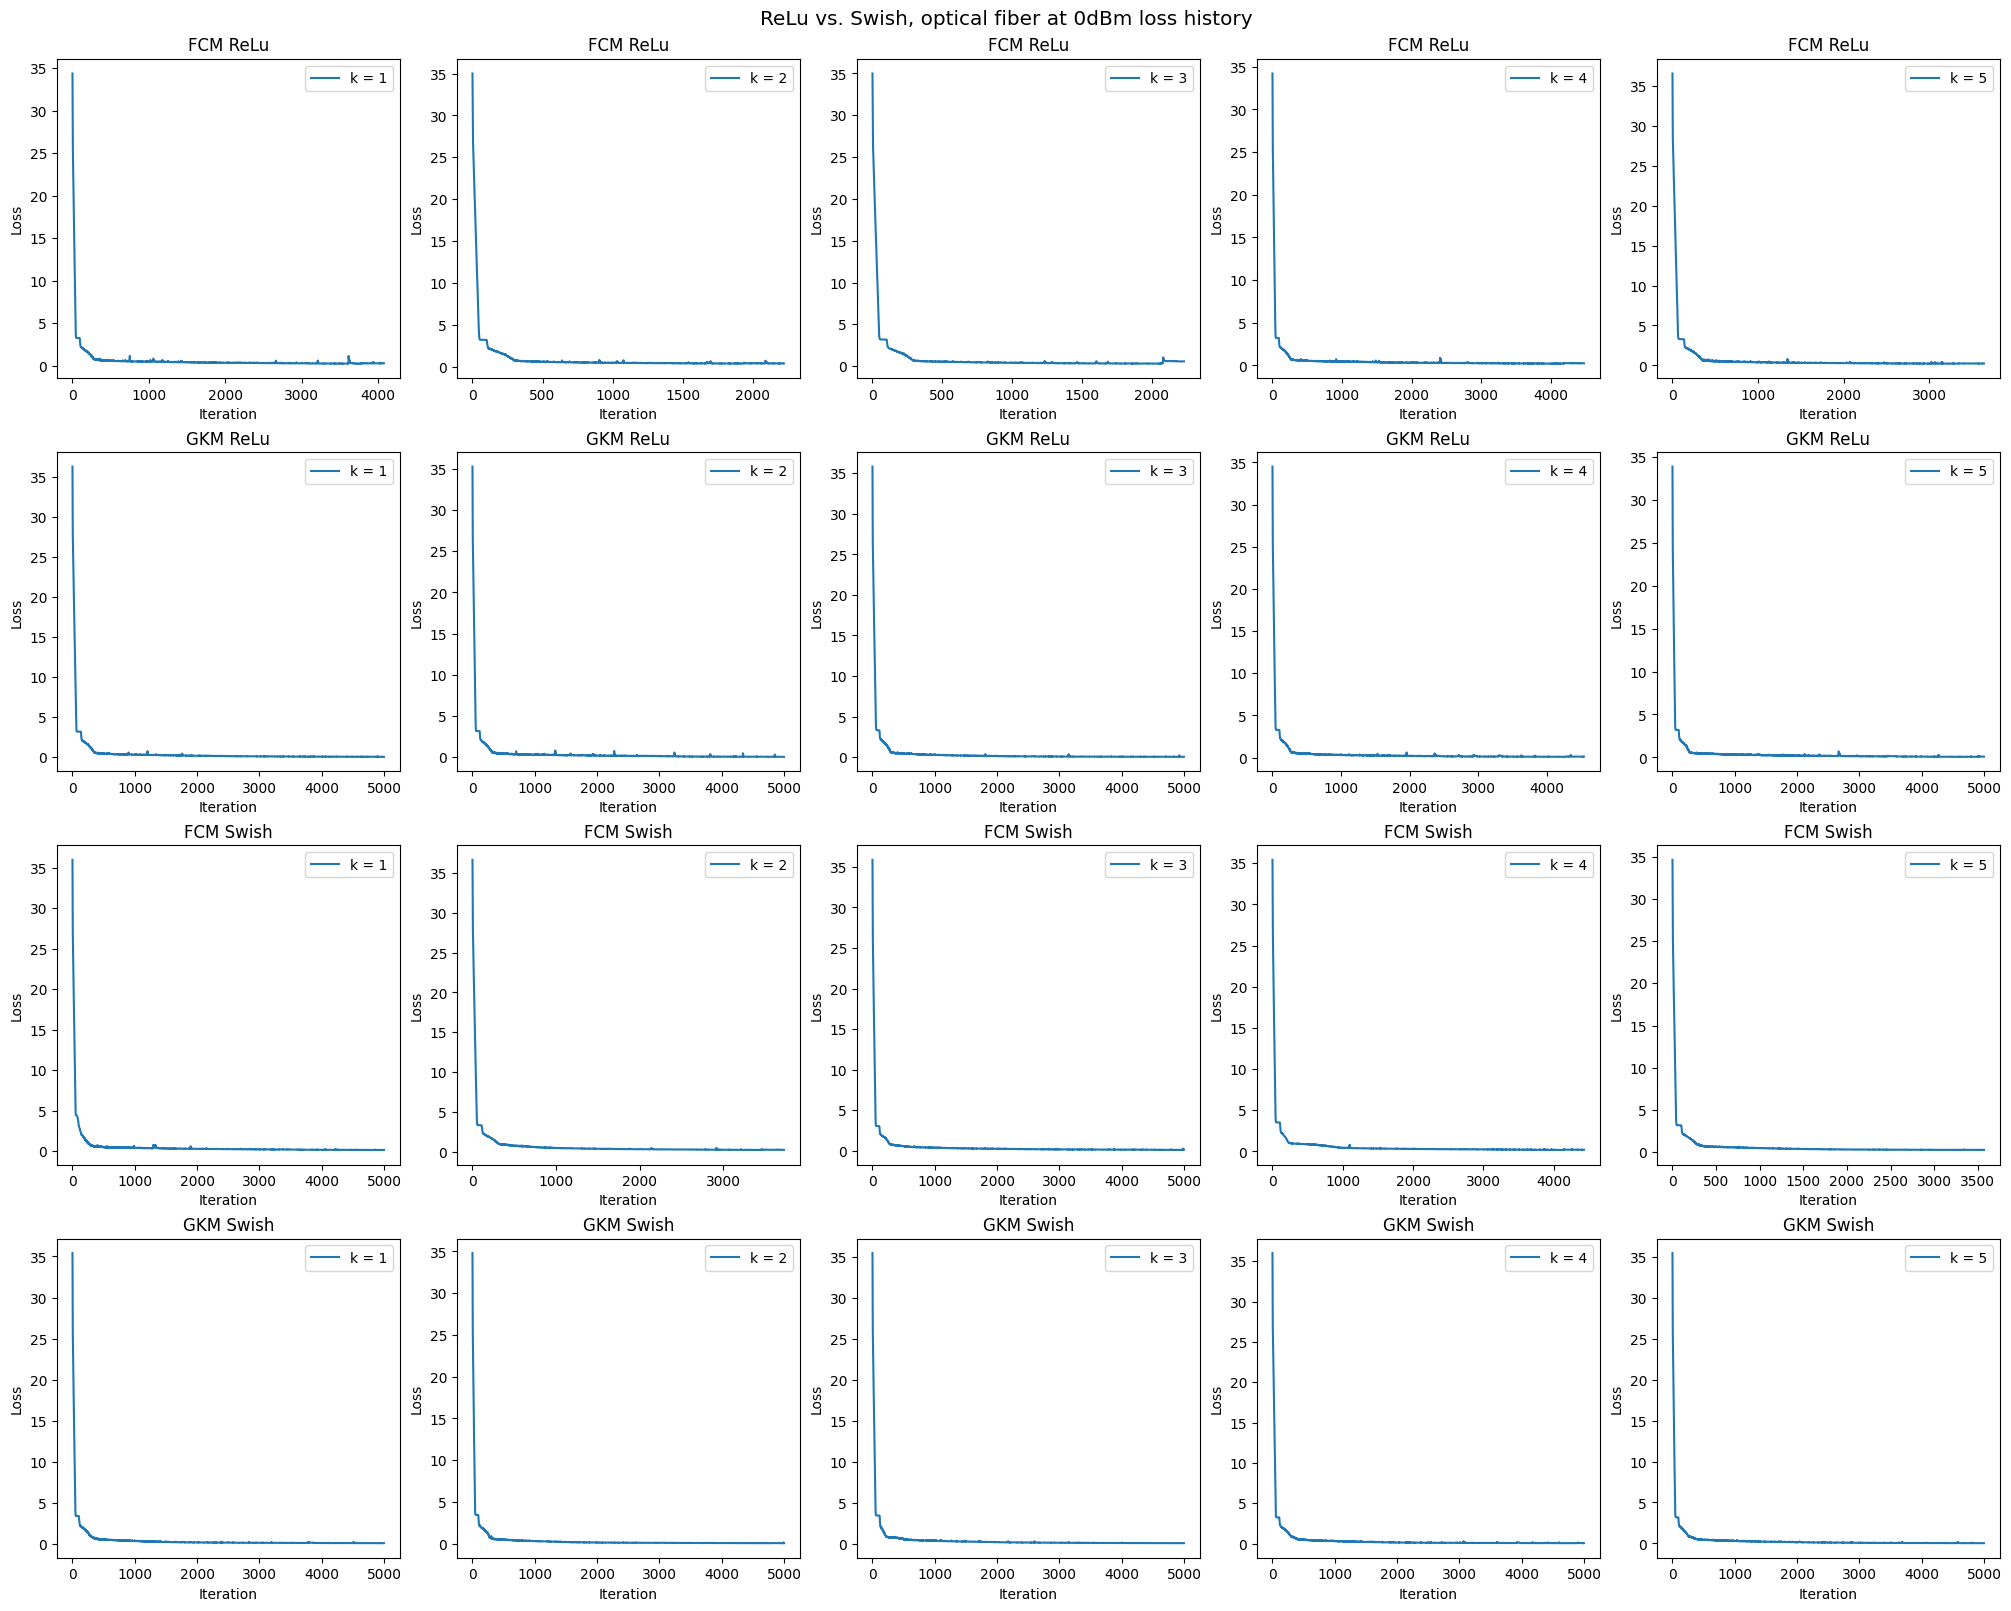

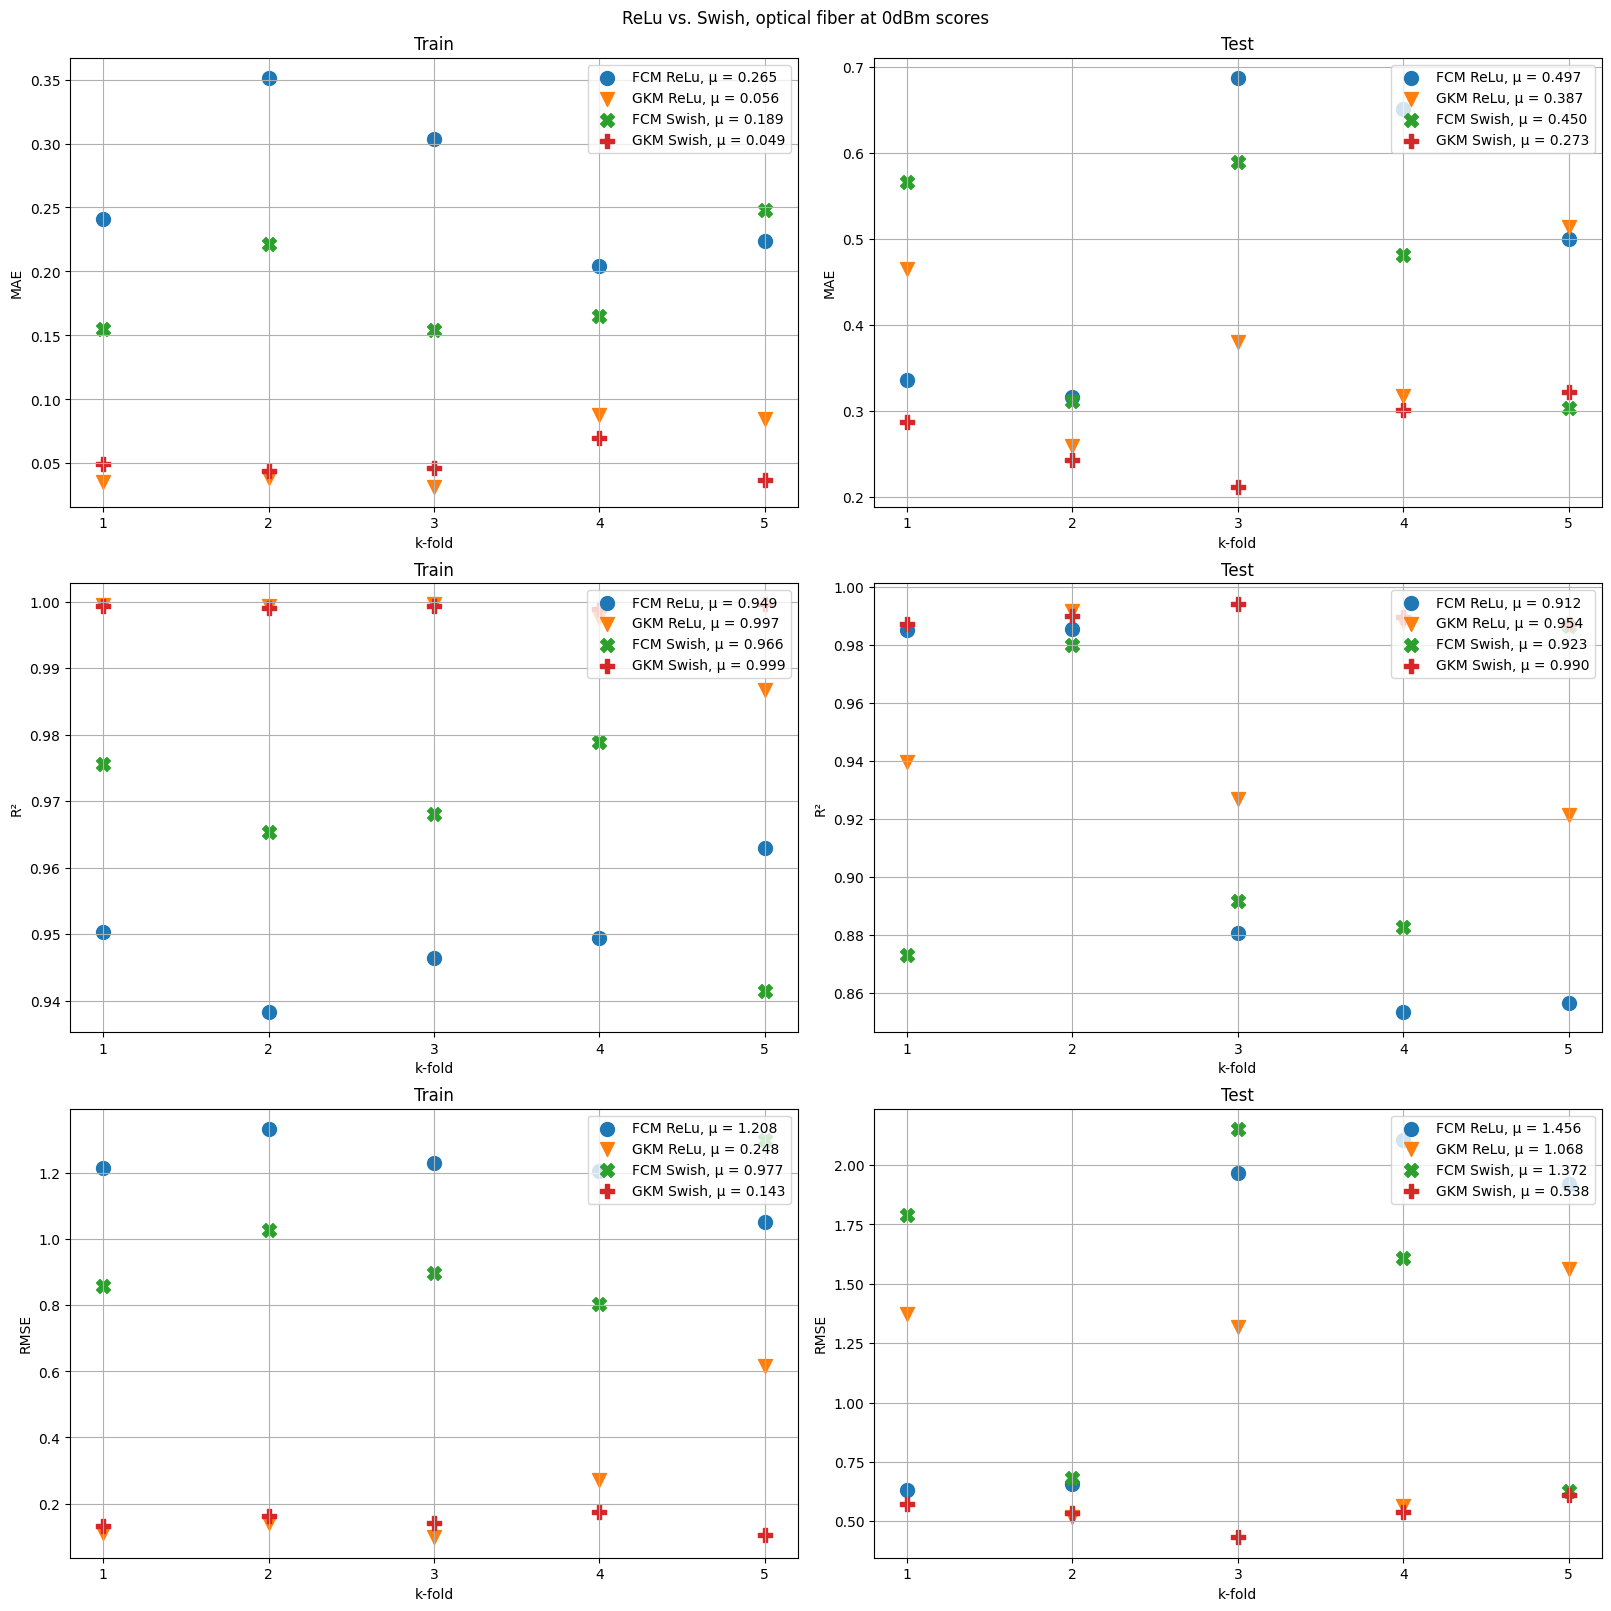

In [60]:
scores = [scores_FCM_relu_fiber0, scores_GKM_relu_fiber0, scores_FCM_swish_fiber0, scores_GKM_swish_fiber0]
plot_activations_scores(scores, "ReLu vs. Swish, optical fiber at 0dBm")

### Crosvalidación para fibra óptica a 9dBm variando la función ReLu por Swish

In [61]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_fiber9 = calc_once("scores_FCM_relu_fiber9", test_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 1544
6/6 [==============================] - 0s 1ms/step
Needed iterations: 1285
6/6 [==============================] - 0s 9ms/step
Needed iterations: 1135
6/6 [==============================] - 0s 2ms/step
Needed iterations: 1306
6/6 [==============================] - 0s 1ms/step
Needed iterations: 1347
6/6 [==============================] - 0s 5ms/step
Time elapsed: 4.70 minutes


In [62]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_fiber9 = calc_once("scores_GKM_relu_fiber9", test_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 1685
6/6 [==============================] - 0s 45ms/step
Needed iterations: 2272
6/6 [==============================] - 0s 1ms/step
Needed iterations: 1383
6/6 [==============================] - 0s 2ms/step
Needed iterations: 2603
6/6 [==============================] - 0s 2ms/step
Needed iterations: 2146
6/6 [==============================] - 0s 1ms/step
Time elapsed: 7.18 minutes


In [63]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_fiber9 = calc_once("scores_FCM_swish_fiber9", test_model, args)

[{'units': 512, 'activation': 'swish'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 2008
6/6 [==============================] - 0s 6ms/step
Needed iterations: 1886
6/6 [==============================] - 0s 5ms/step
Needed iterations: 1854
6/6 [==============================] - 0s 2ms/step
Needed iterations: 1991
6/6 [==============================] - 0s 1ms/step
Needed iterations: 2438
6/6 [==============================] - 0s 1ms/step
Time elapsed: 12.81 minutes


In [64]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_fiber9 = calc_once("scores_GKM_swish_fiber9", test_model, args)

[{'units': 512, 'activation': 'swish'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 1937
6/6 [==============================] - 0s 1ms/step
Needed iterations: 2640
6/6 [==============================] - 0s 5ms/step
Needed iterations: 1406
6/6 [==============================] - 0s 1ms/step
Needed iterations: 4186
6/6 [==============================] - 0s 1ms/step
Needed iterations: 4258
6/6 [==============================] - 0s 1ms/step
Time elapsed: 6.17 minutes


In [65]:
%store scores_FCM_relu_fiber9
%store scores_GKM_relu_fiber9
%store scores_FCM_swish_fiber9
%store scores_GKM_swish_fiber9

Stored 'scores_FCM_relu_fiber9' (dict)
Stored 'scores_GKM_relu_fiber9' (dict)
Stored 'scores_FCM_swish_fiber9' (dict)
Stored 'scores_GKM_swish_fiber9' (dict)


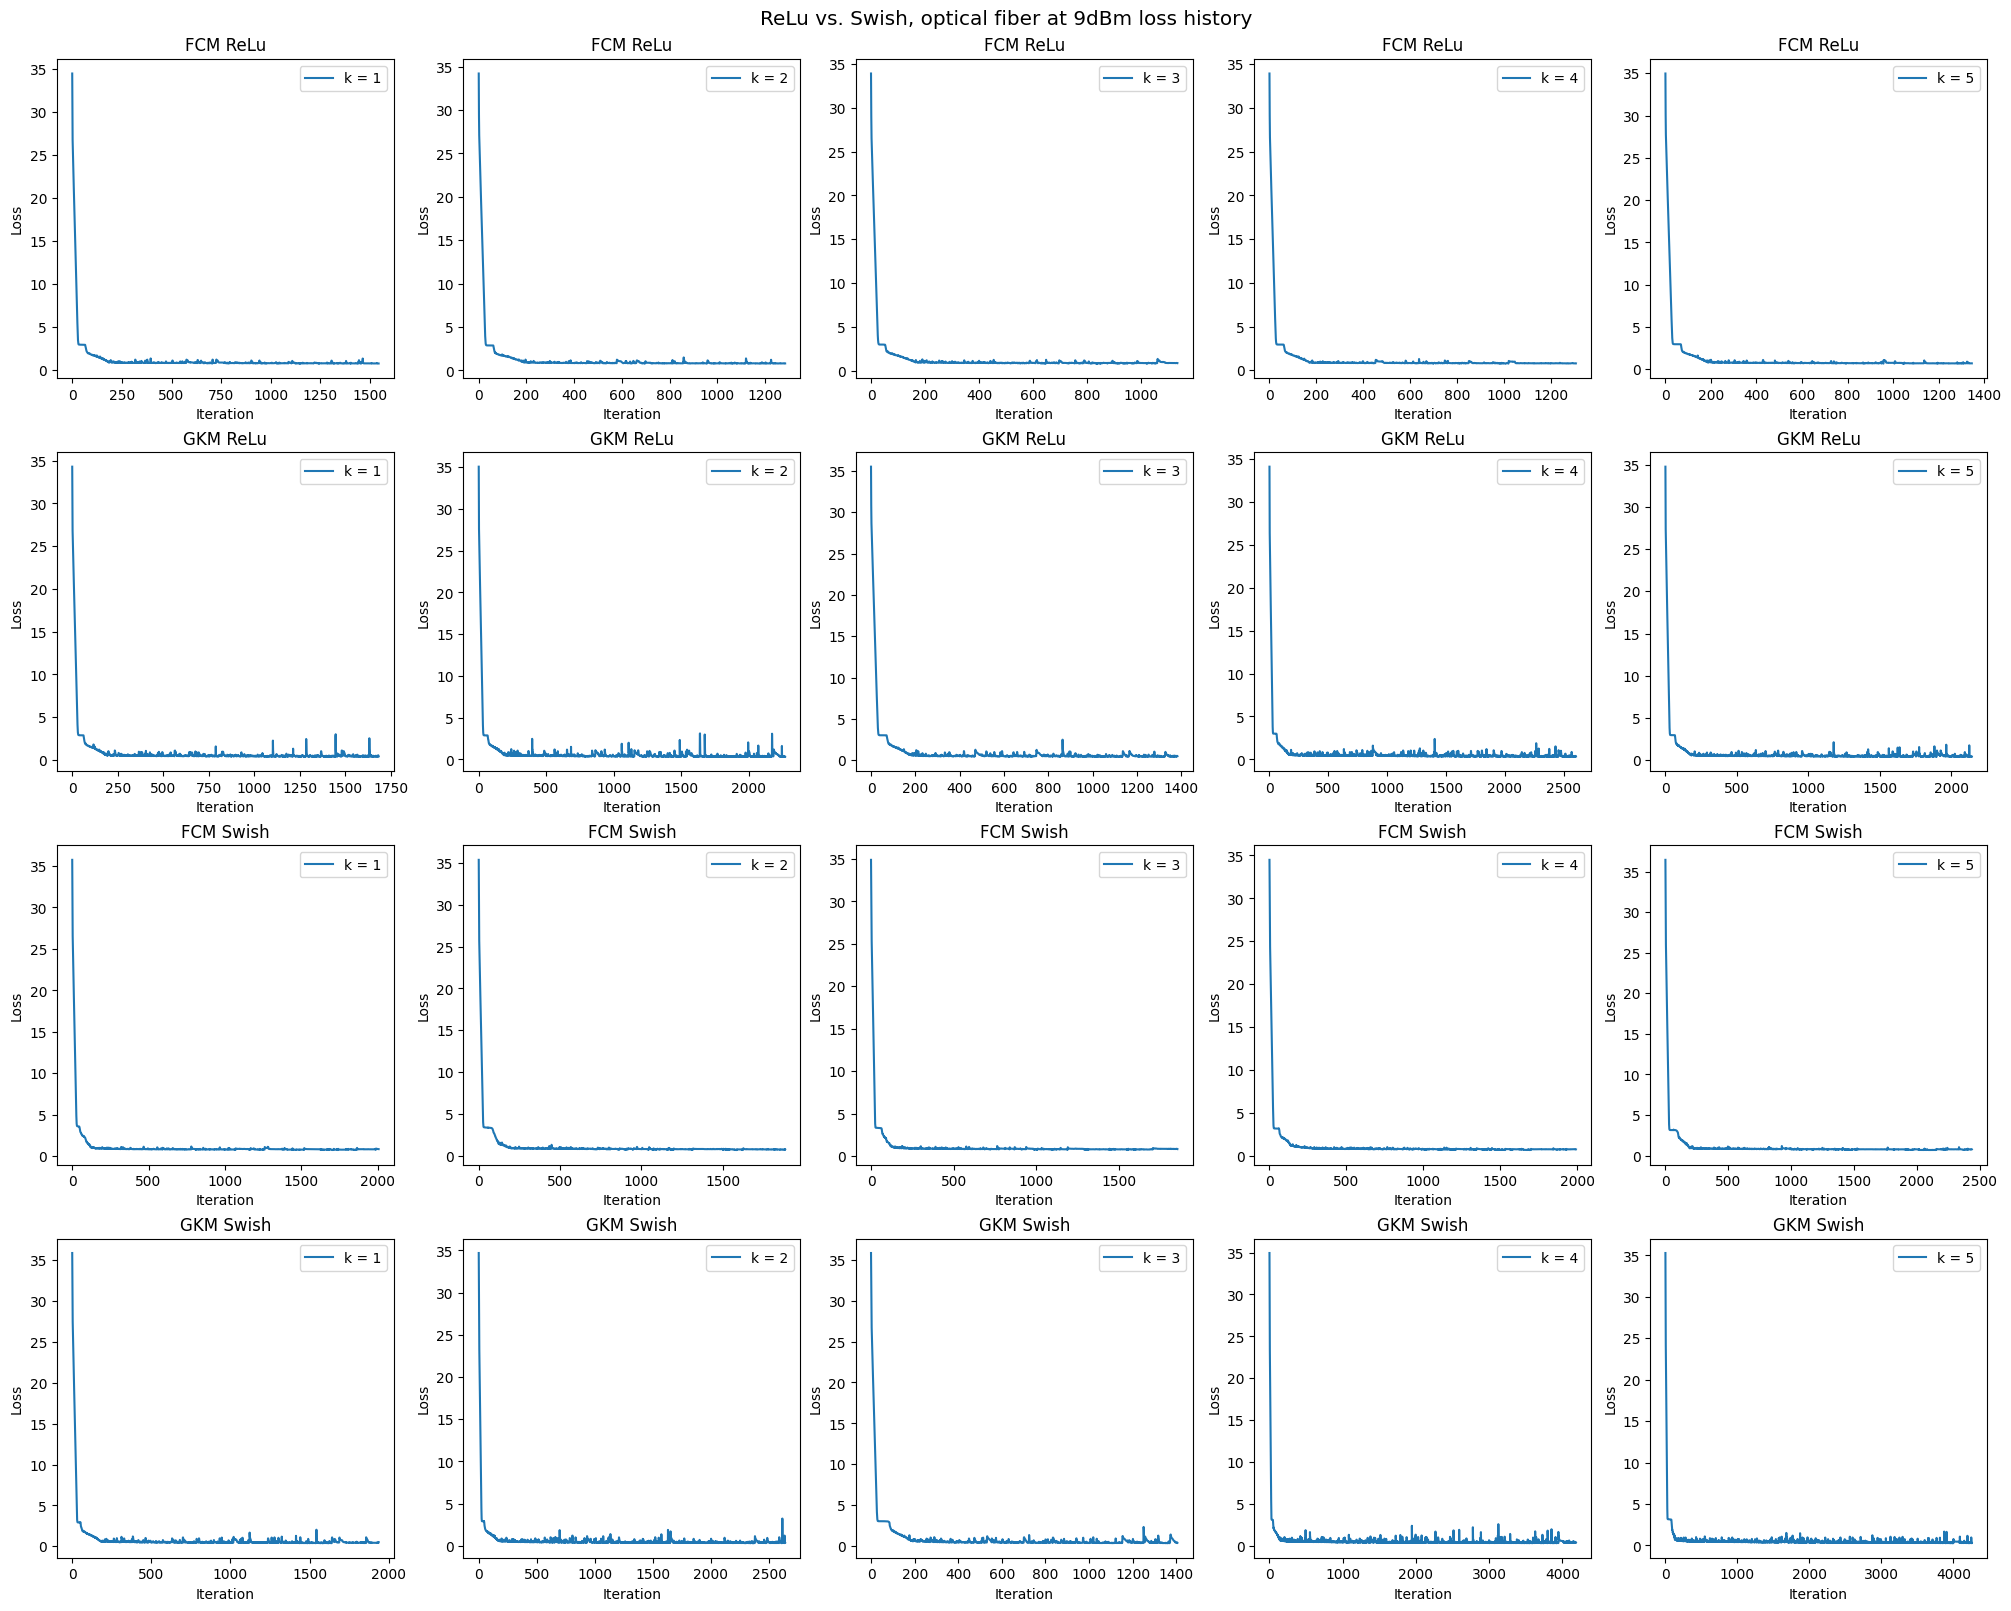

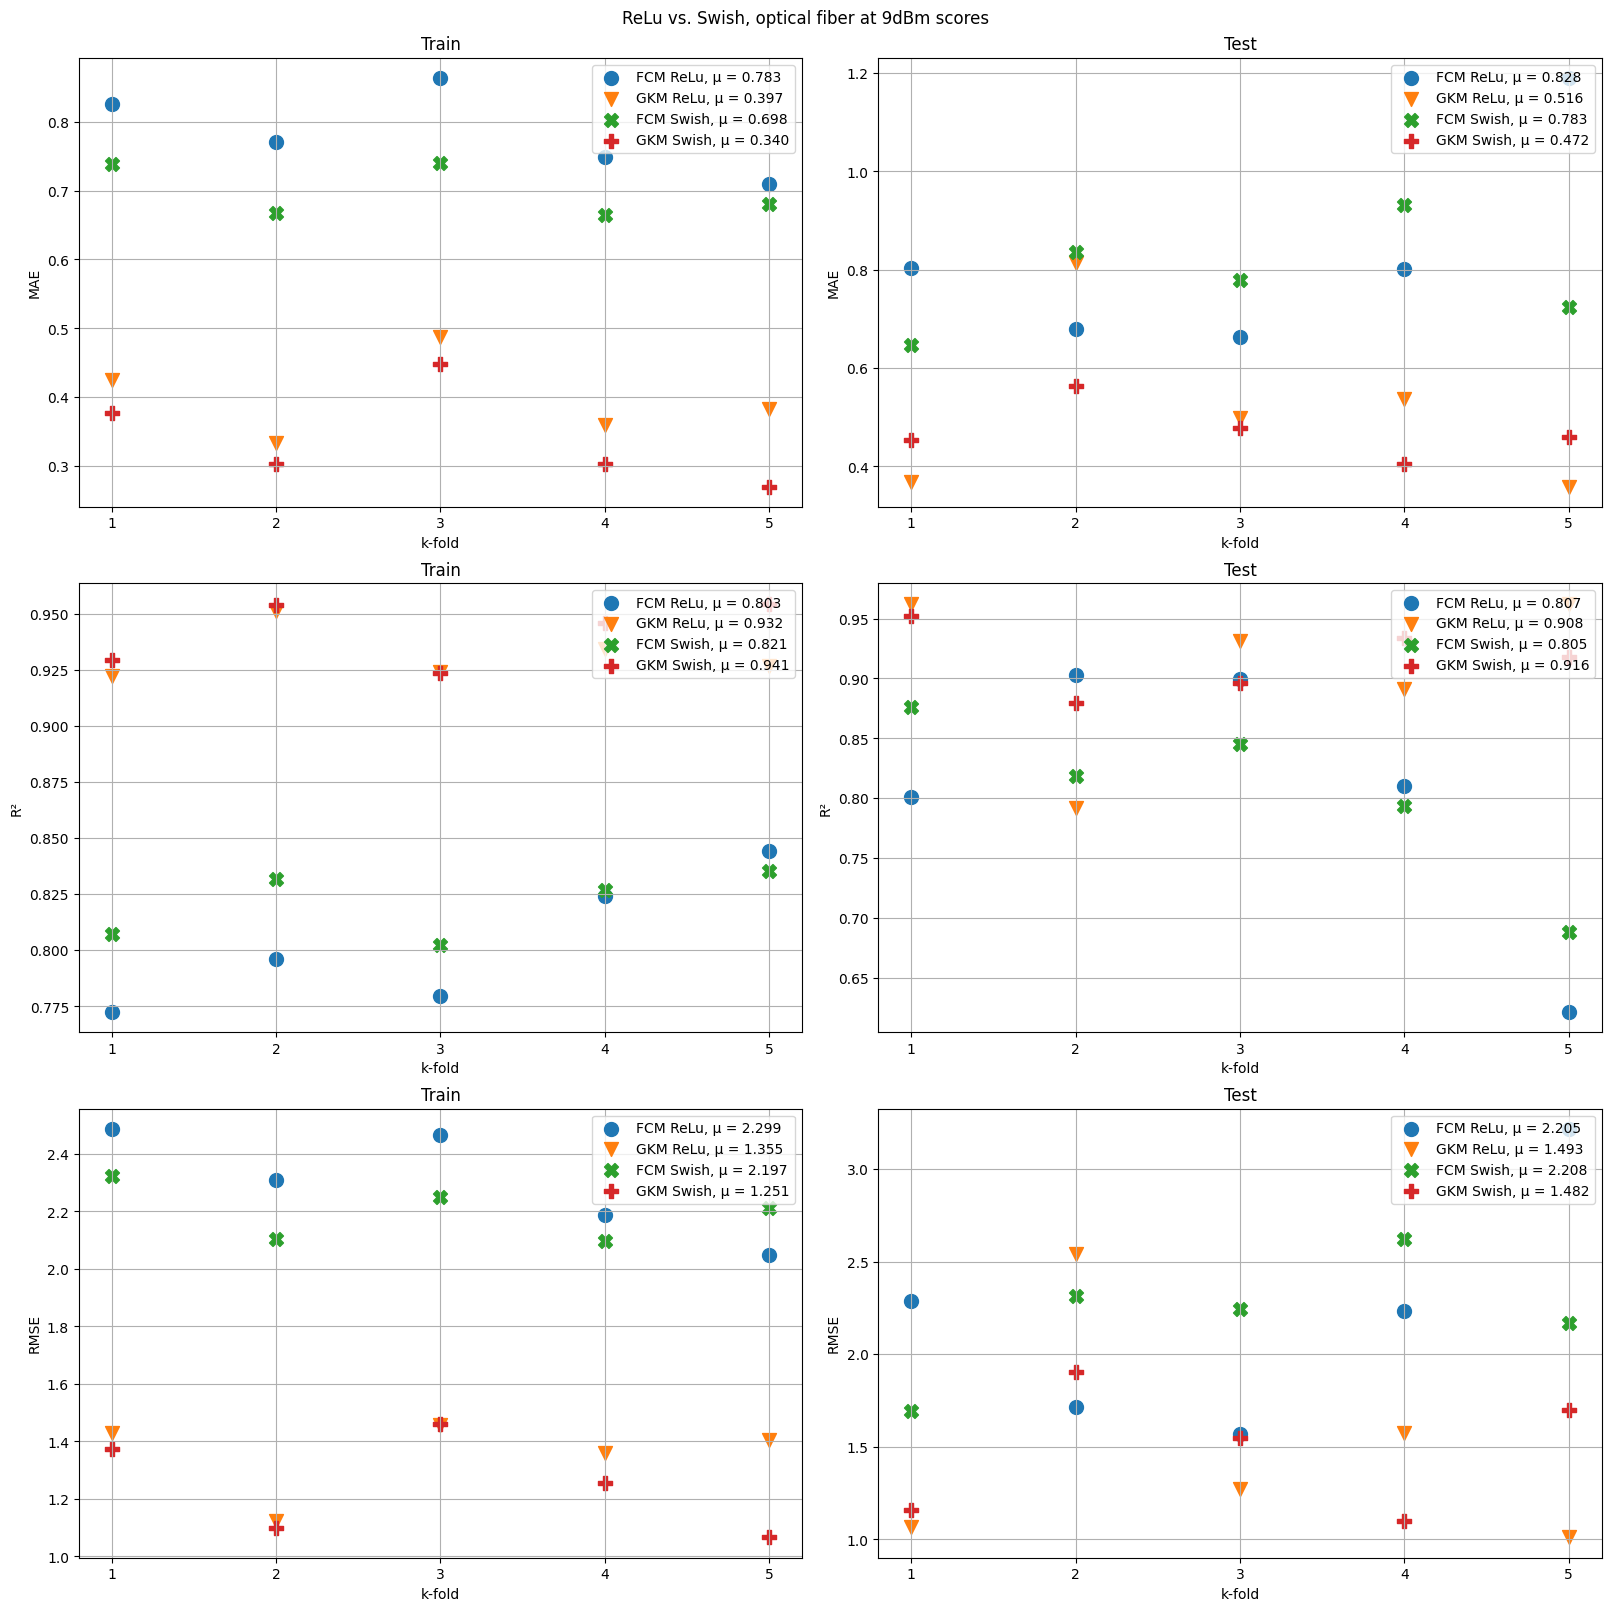

In [66]:
scores = [scores_FCM_relu_fiber9, scores_GKM_relu_fiber9, scores_FCM_swish_fiber9, scores_GKM_swish_fiber9]
plot_activations_scores(scores, "ReLu vs. Swish, optical fiber at 9dBm")

## FCM y GKM en escenario B2B variando el número de capas ocultas

In [ ]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_FCM_B2B_1HL = calc_once("scores_FCM_B2B_1HL", test_model, args)

In [ ]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_FCM_B2B_2HL = calc_once("scores_FCM_B2B_2HL", test_model, args)

In [ ]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_B2B_3HL = calc_once("scores_FCM_B2B_3HL", test_model, args)

In [ ]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_FCM_B2B_4HL = calc_once("scores_FCM_B2B_4HL", test_model, args)

## FCM y GKM en escenario con fibra óptica a 0dBm variando el número de capas ocultas

In [ ]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_FCM_fiber0_1HL = calc_once("scores_FCM_fiber0_1HL", test_model, args)

In [ ]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_FCM_fiber0_2HL = calc_once("scores_FCM_fiber0_2HL", test_model, args)

In [ ]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_fiber0_3HL = calc_once("scores_FCM_fiber0_3HL", test_model, args)

In [ ]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_FCM_fiber0_4HL = calc_once("scores_FCM_fiber0_4HL", test_model, args)

## FCM y GKM en escenario con fibra óptica a 9dBm variando el número de capas ocultas

In [ ]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_FCM_fiber9_1HL = calc_once("scores_FCM_fiber9_1HL", test_model, args)

In [ ]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_FCM_fiber9_2HL = calc_once("scores_FCM_fiber9_2HL", test_model, args)

In [ ]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_fiber9_3HL = calc_once("scores_FCM_fiber9_3HL", test_model, args)

In [ ]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_FCM_fiber9_4HL = calc_once("scores_FCM_fiber9_4HL", test_model, args)